In [1]:
import os

# Change to the parent directory
os.chdir('..')

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from src.data_processing import identify_charging_cycles
from src.model_fitting import fit_model
from src.plotting import plot_scatterplot, plot_fitted, print_fitted_params
from src.excelfile_loader import load_excel
# %matplotlib inline


## chronopotentiometry For CNF Paper.xlsx visualization

In [2]:
# Load the Excel file
file_path = 'chronopotentiometry For CNF Paper.xlsx'
xls = load_excel(file_path)

### first_sheet (85C)

In [3]:
# Load the first sheet into a DataFrame
first_sheet_df = xls.parse(xls.sheet_names[0], header=1)
first_sheet_df = first_sheet_df[['time/hours', 'Ewe/mV.4']]


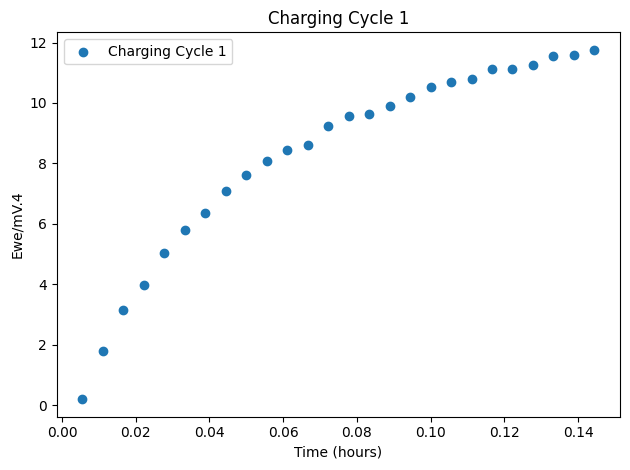

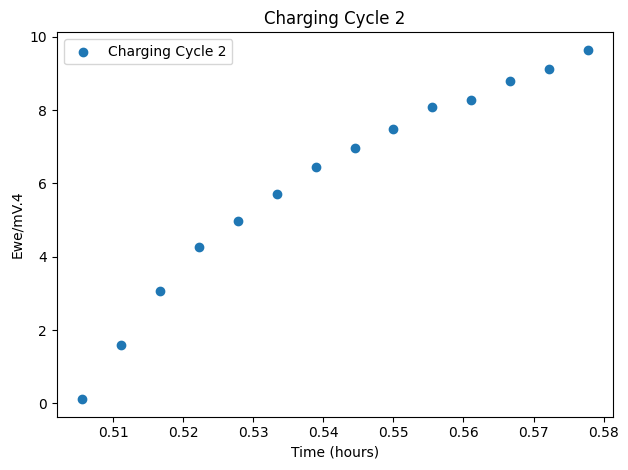

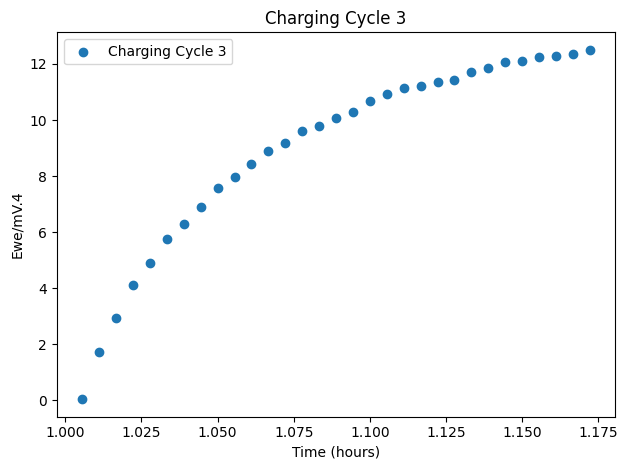

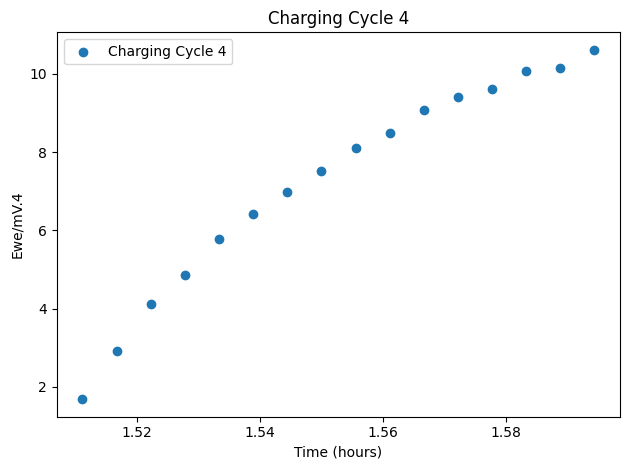

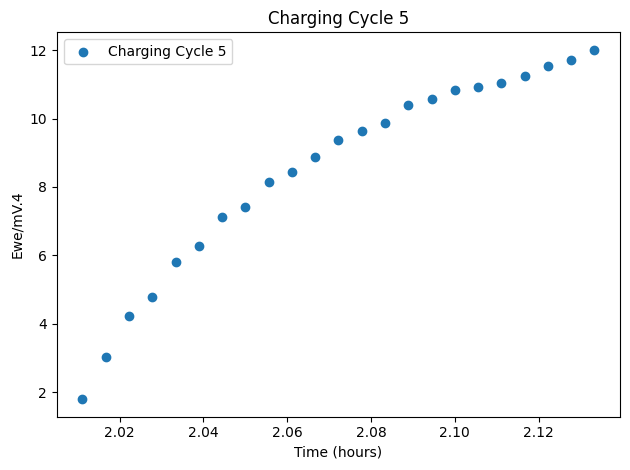

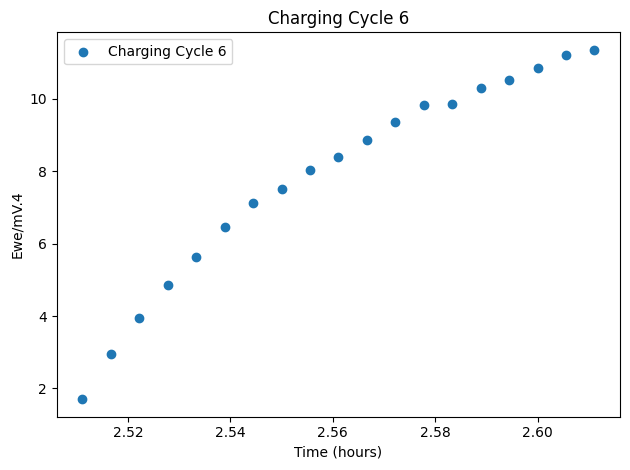

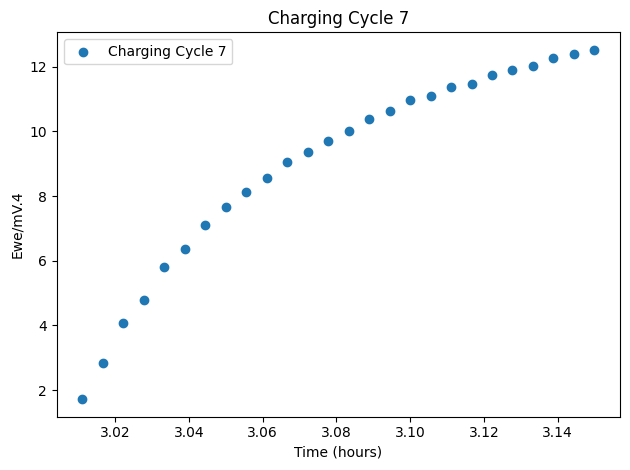

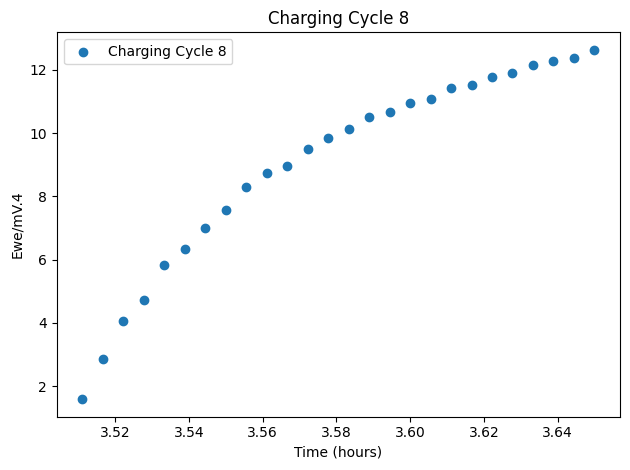

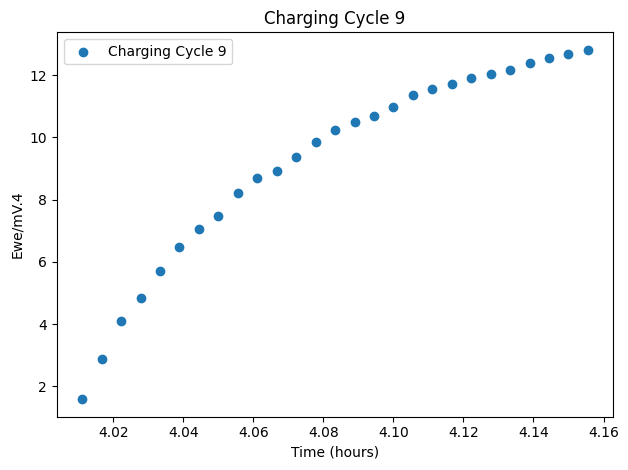

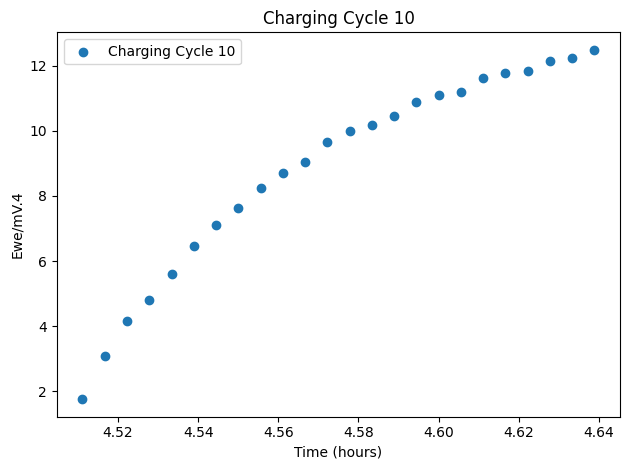

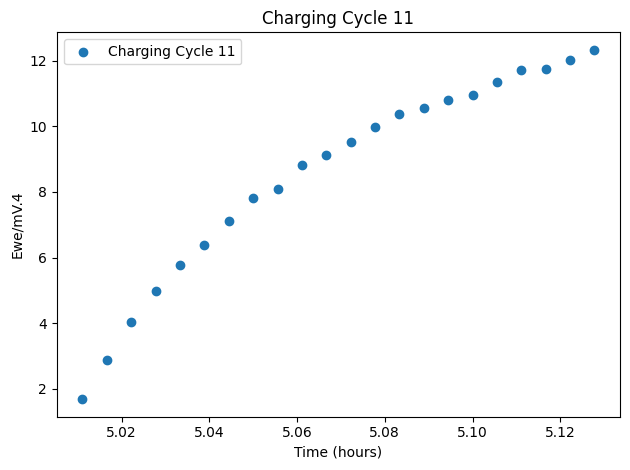

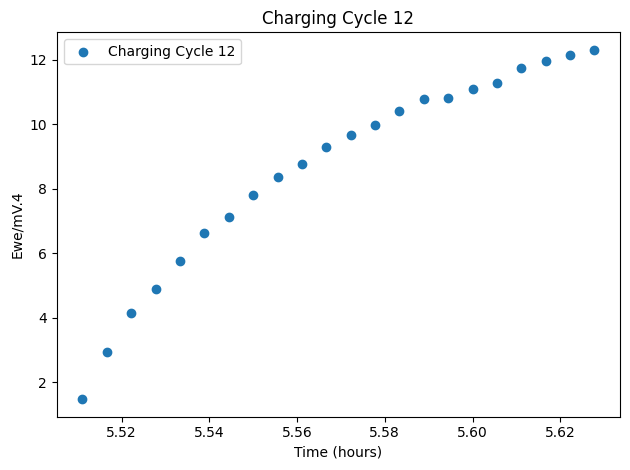

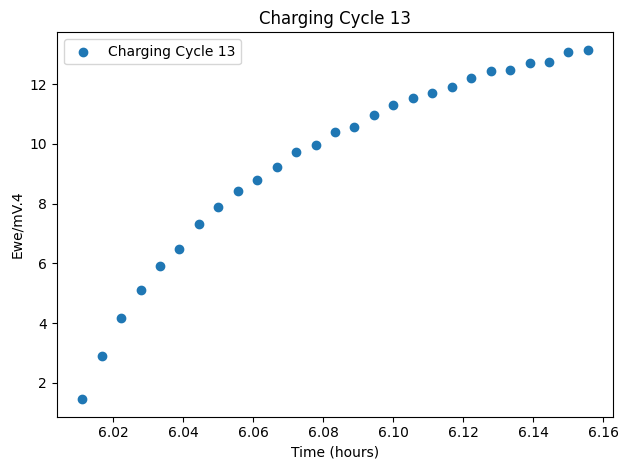

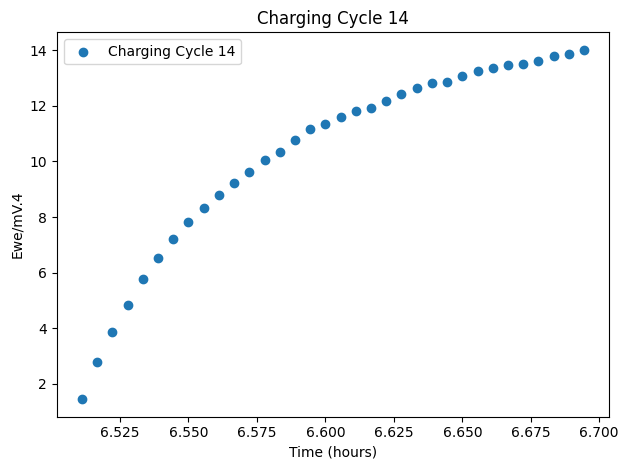

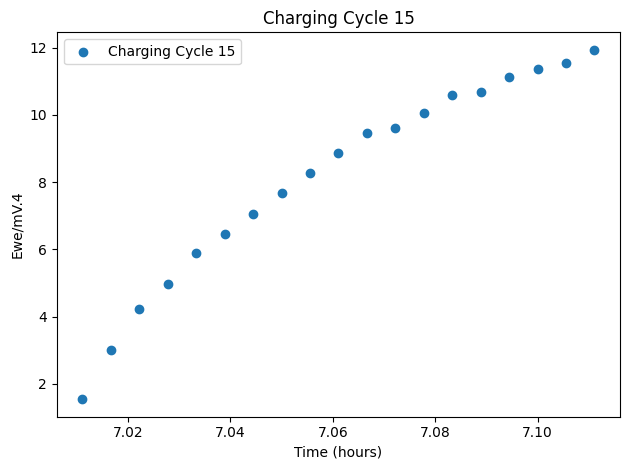

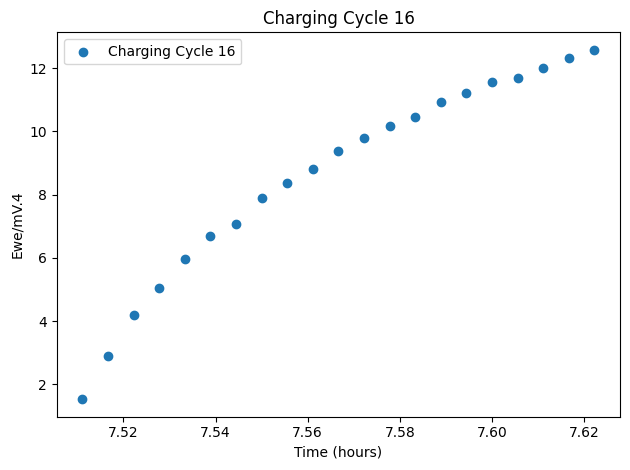

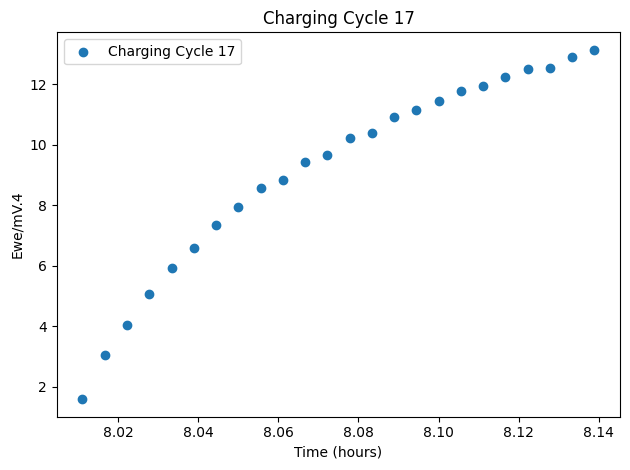

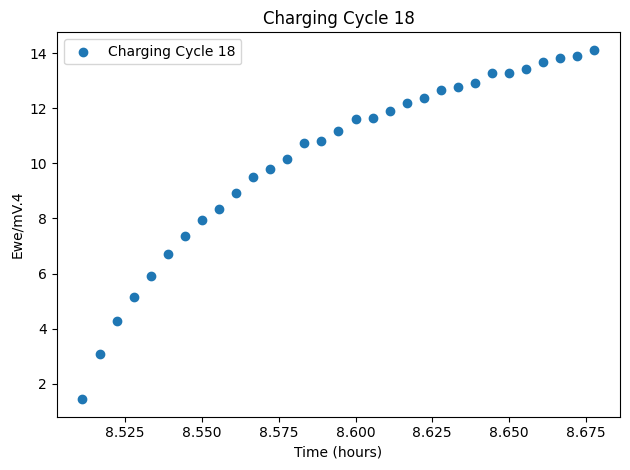

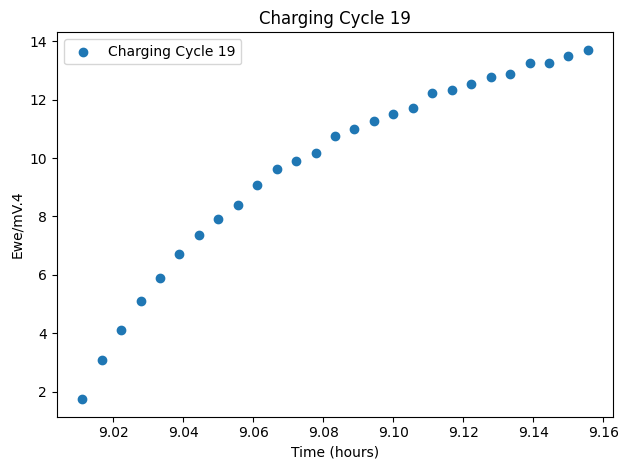

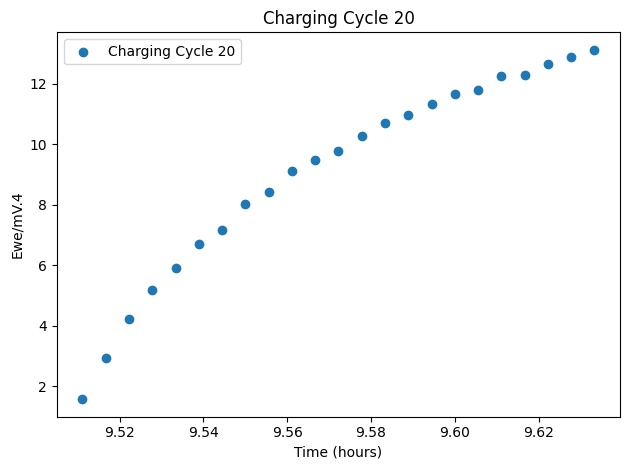

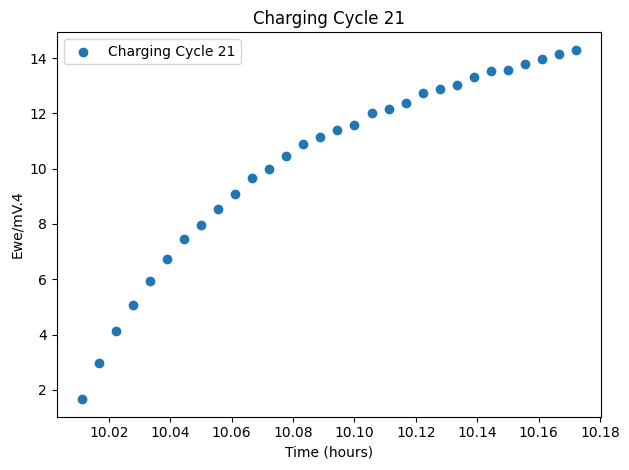

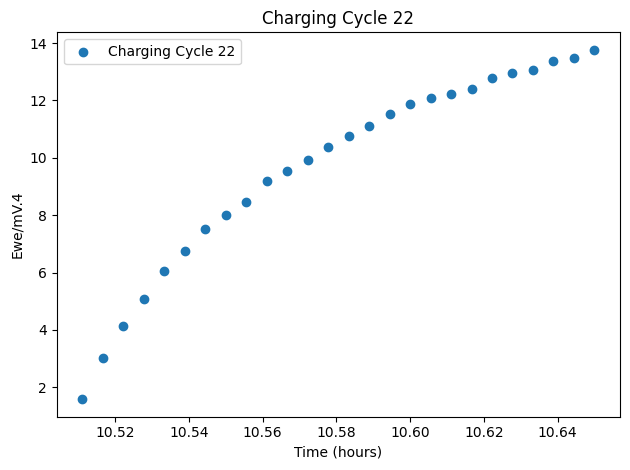

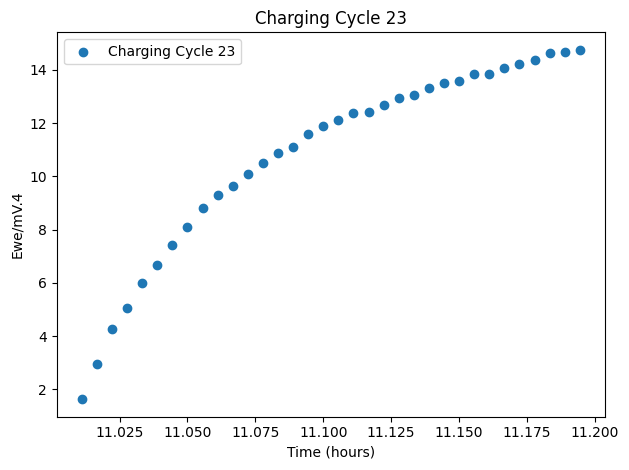

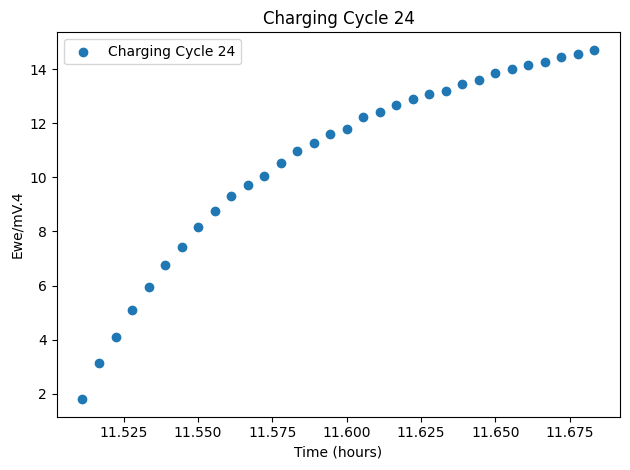

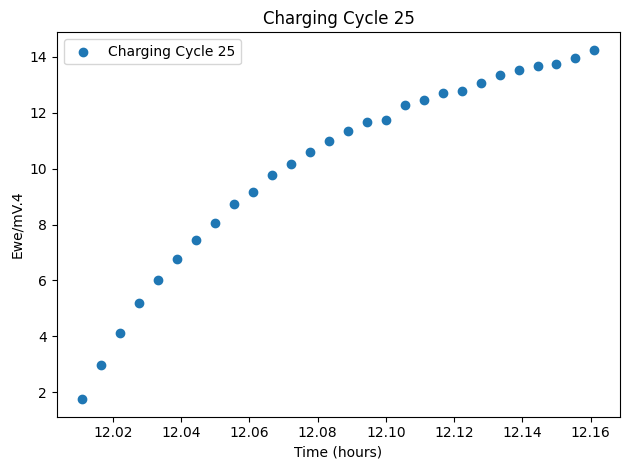

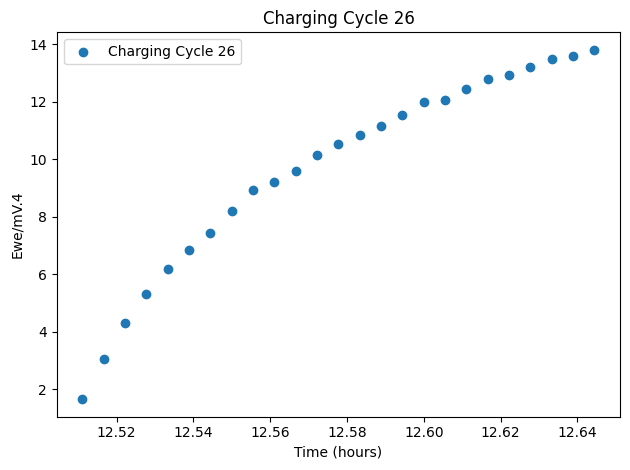

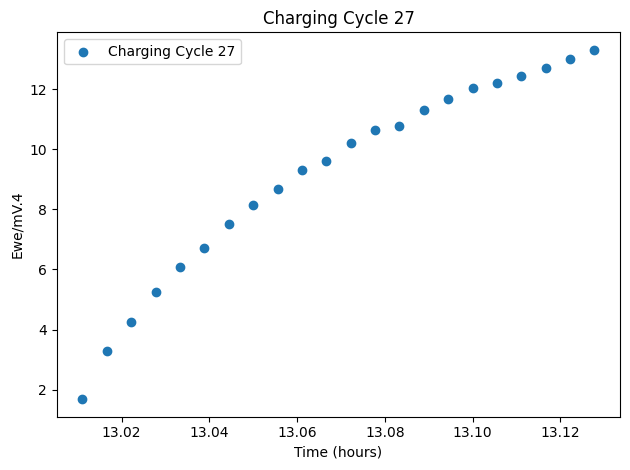

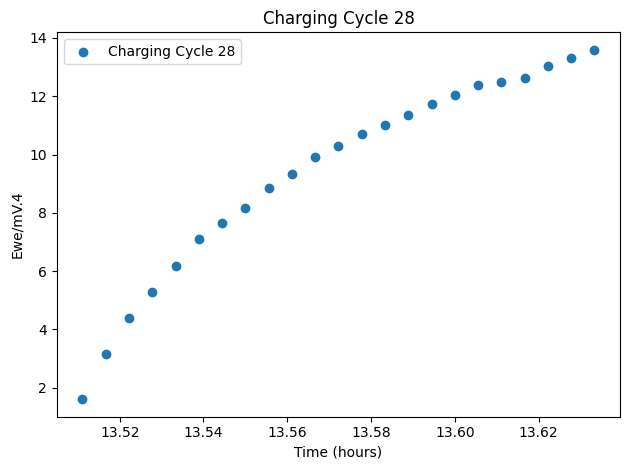

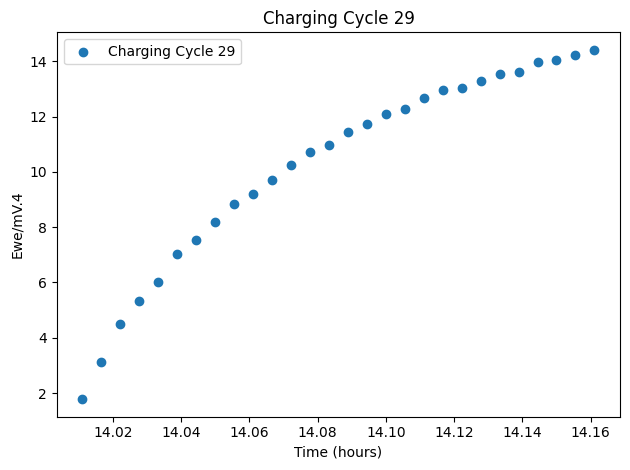

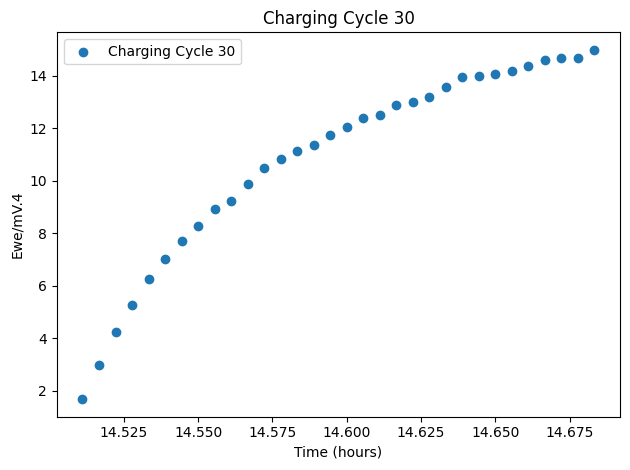

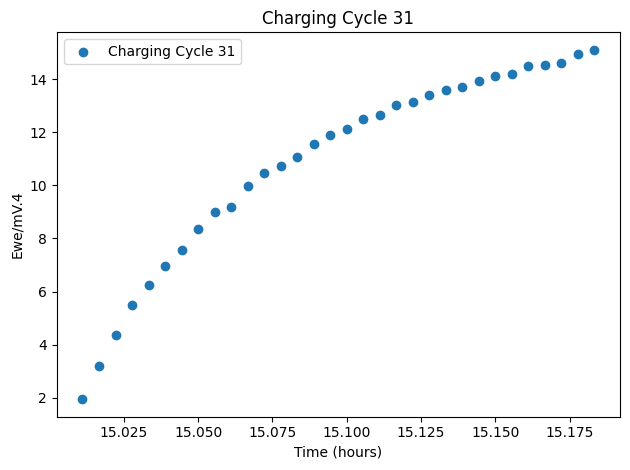

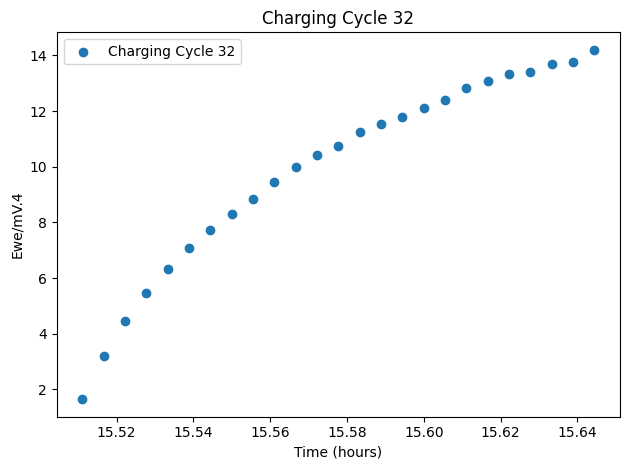

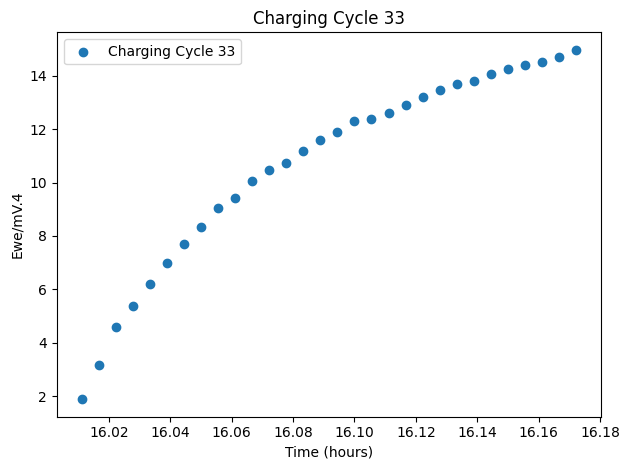

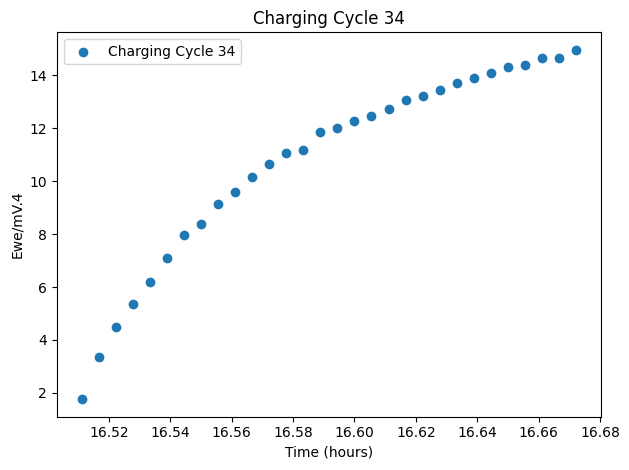

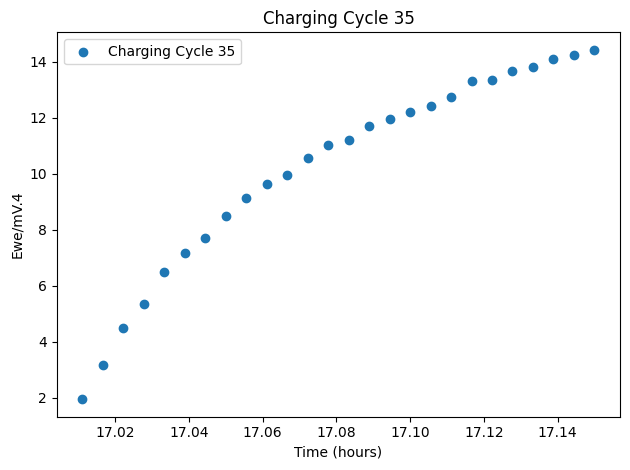

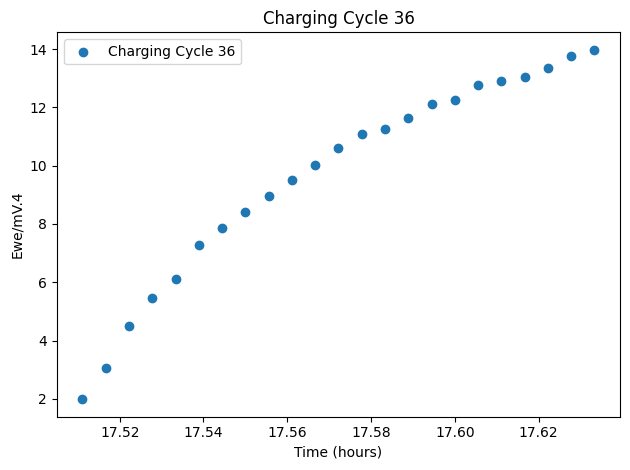

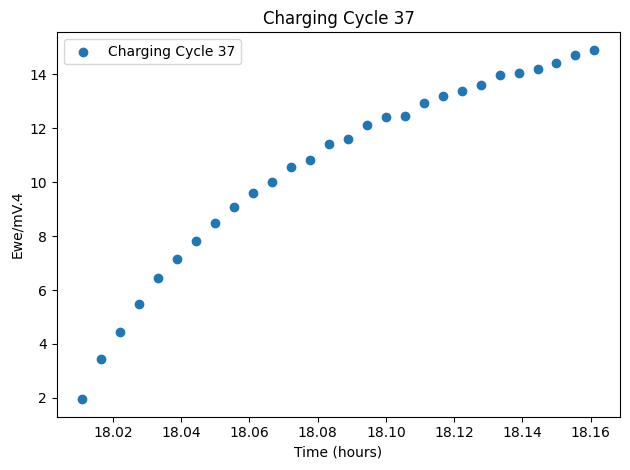

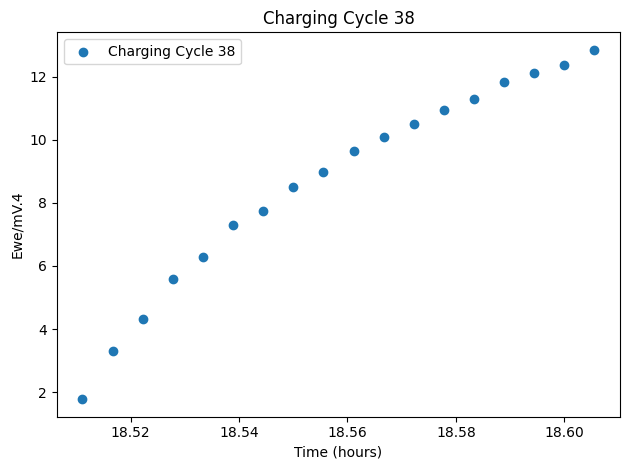

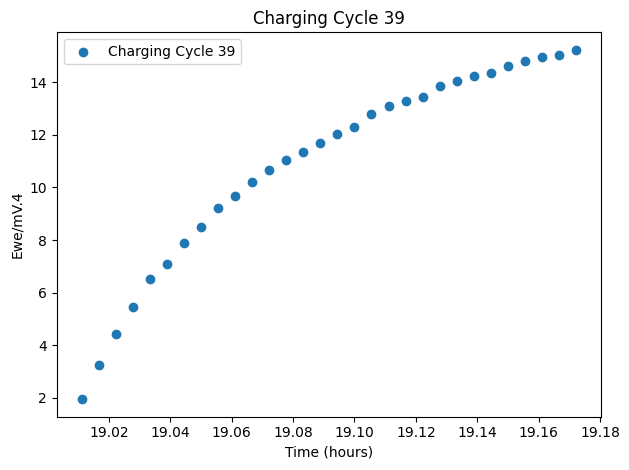

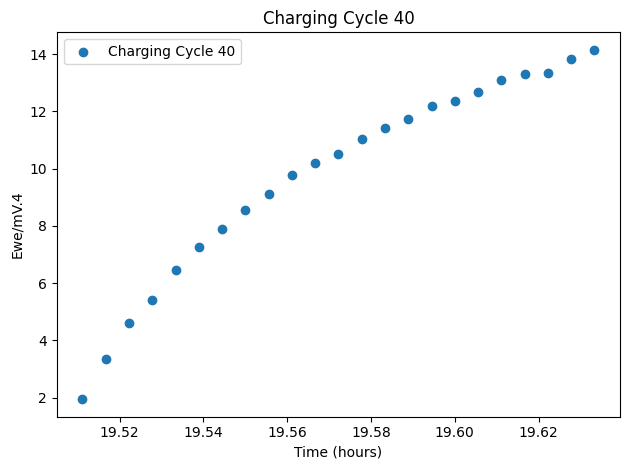

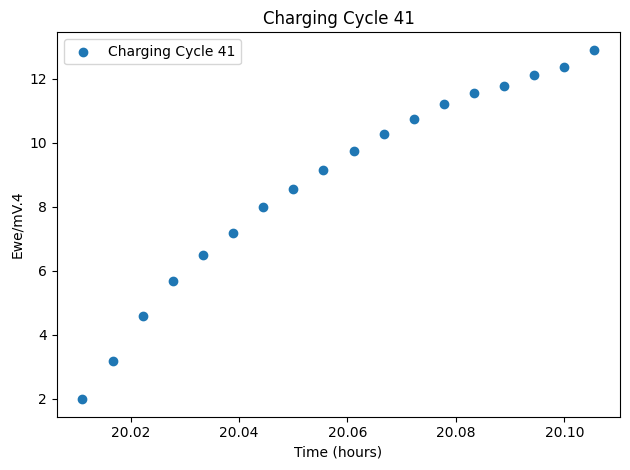

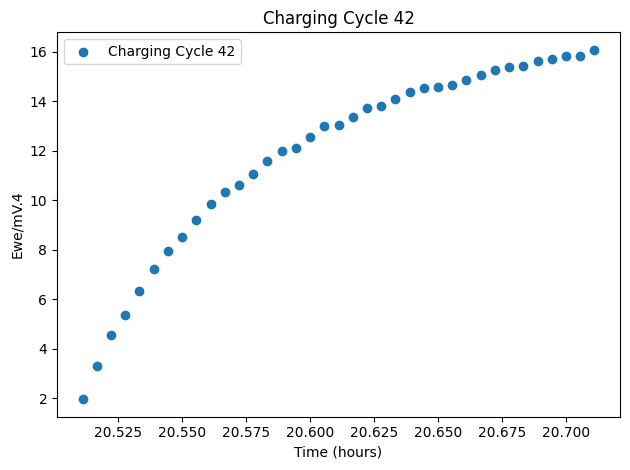

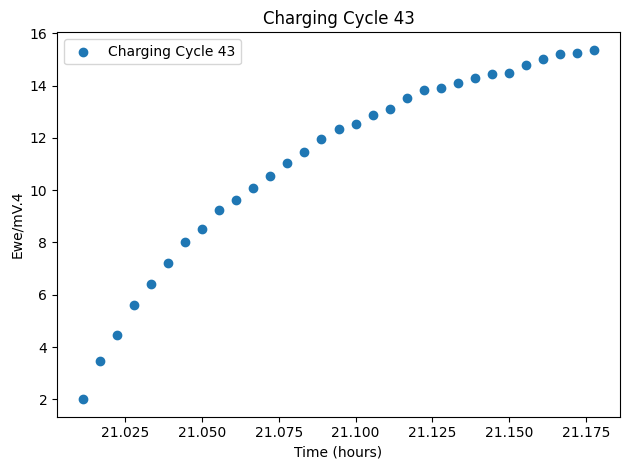

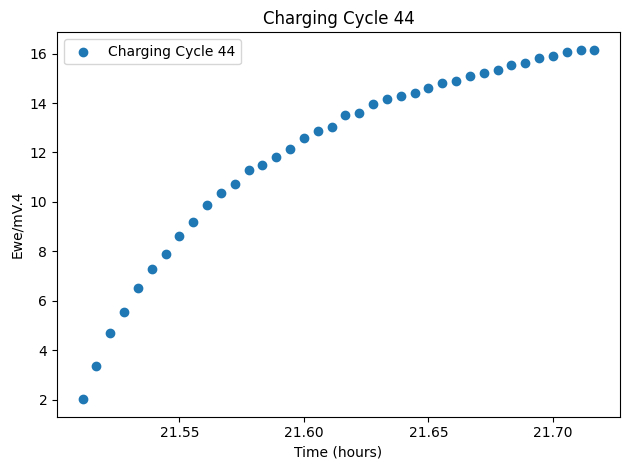

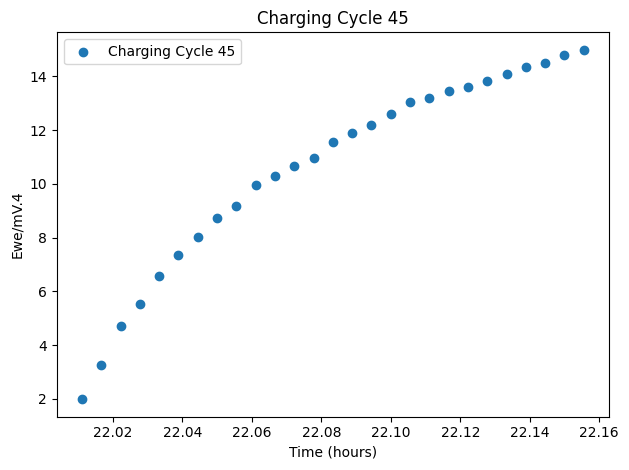

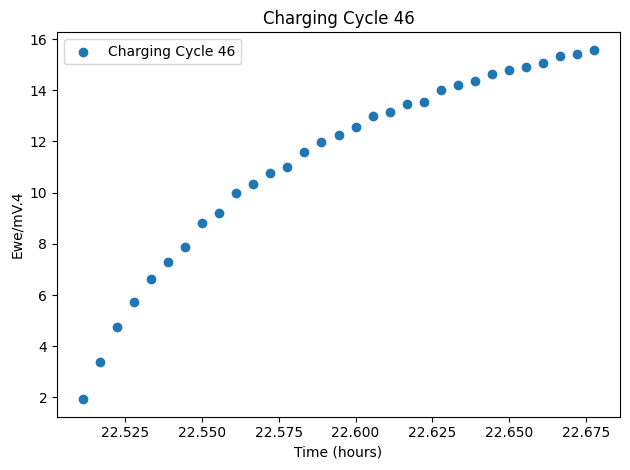

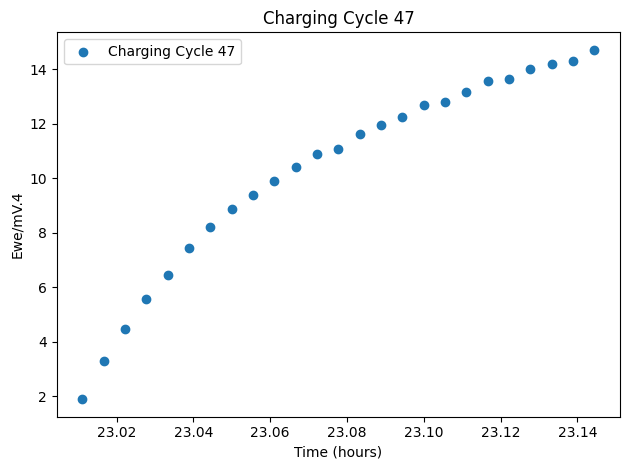

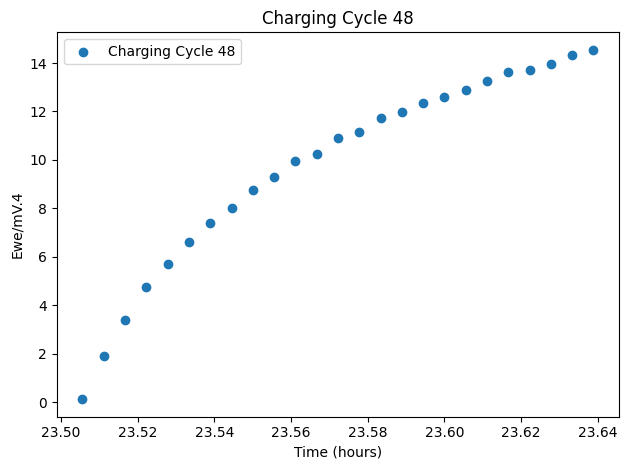

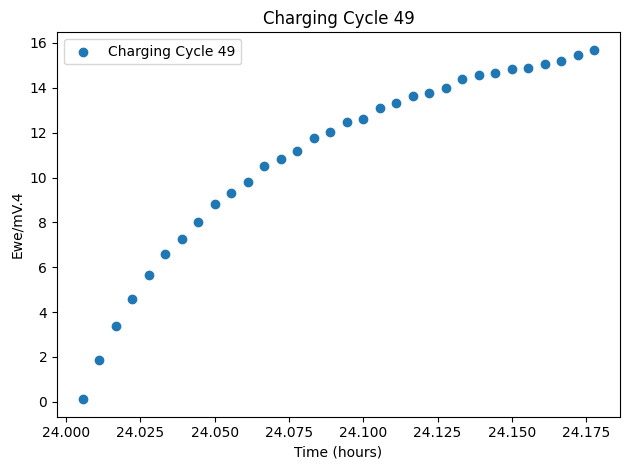

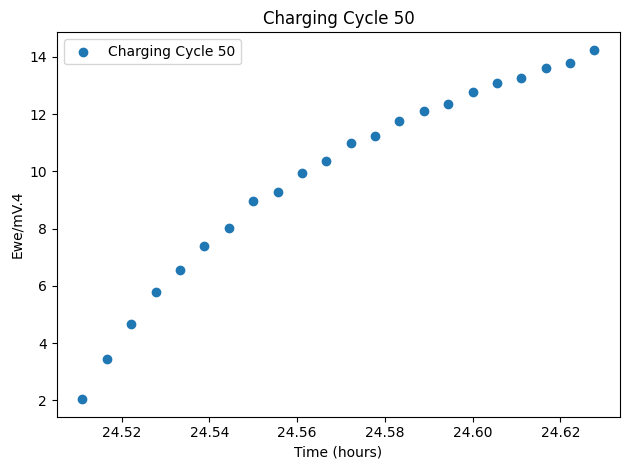

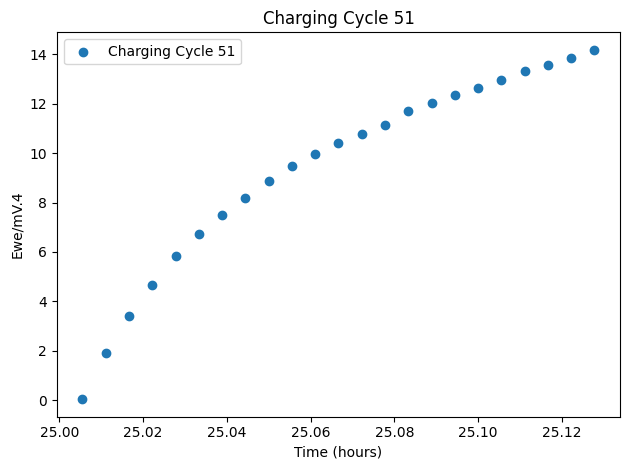

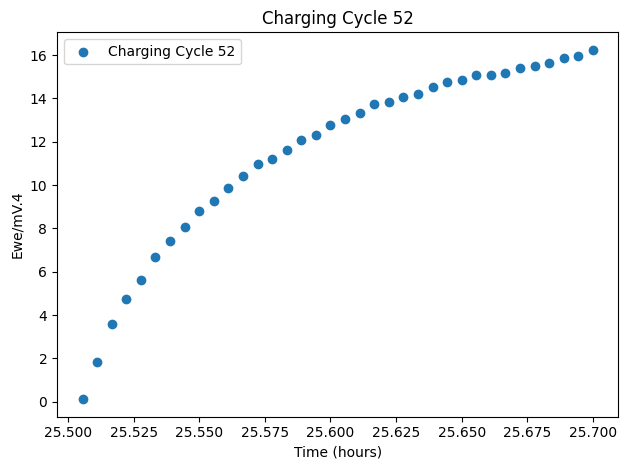

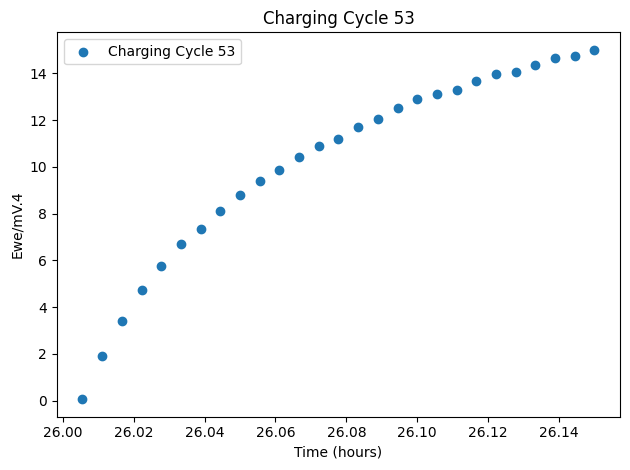

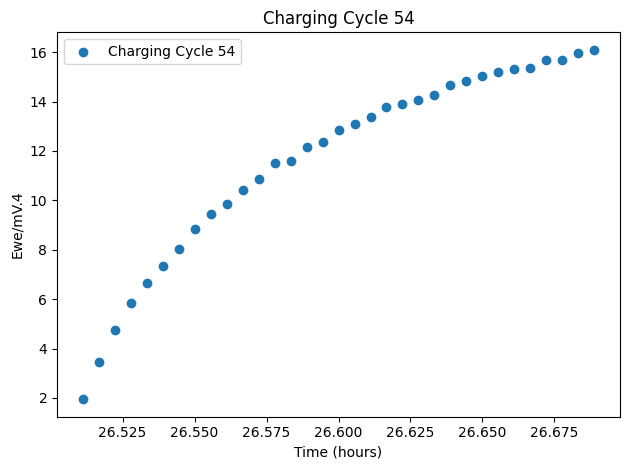

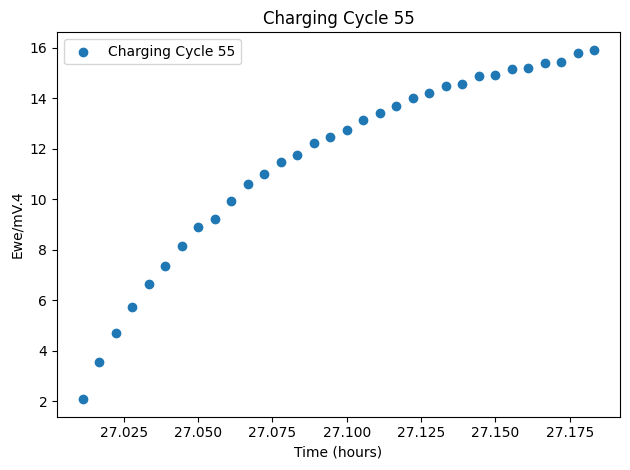

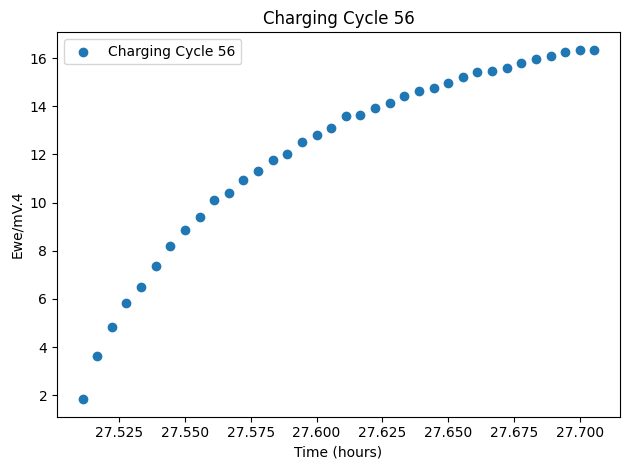

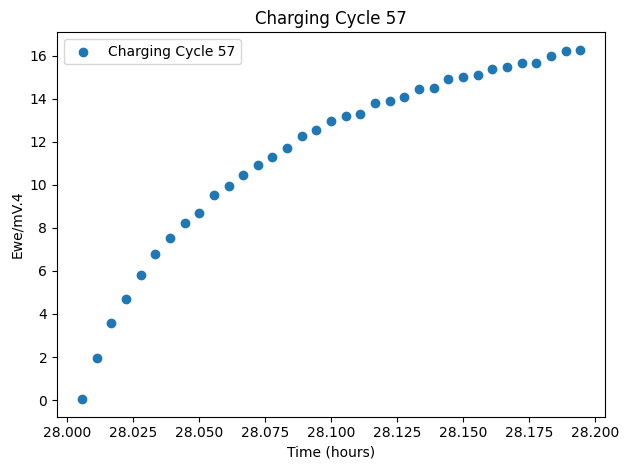

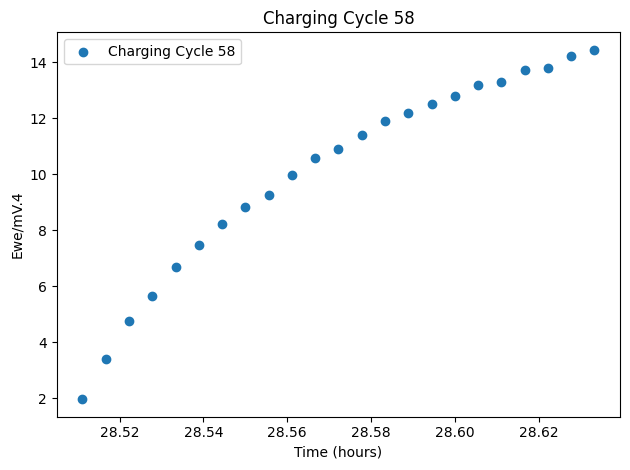

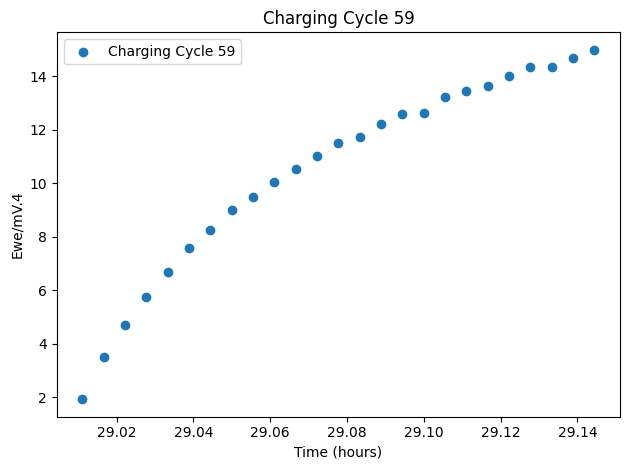

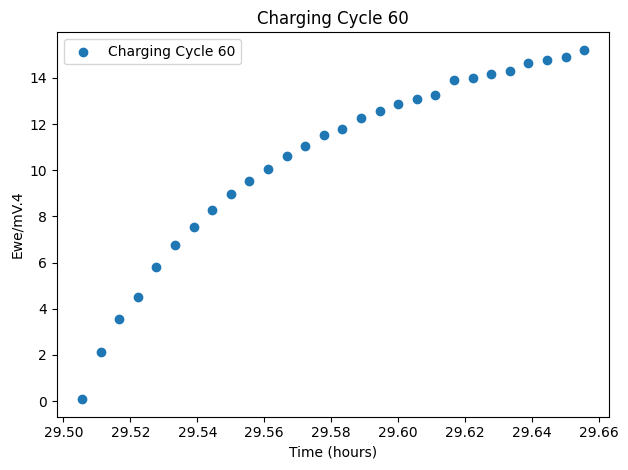

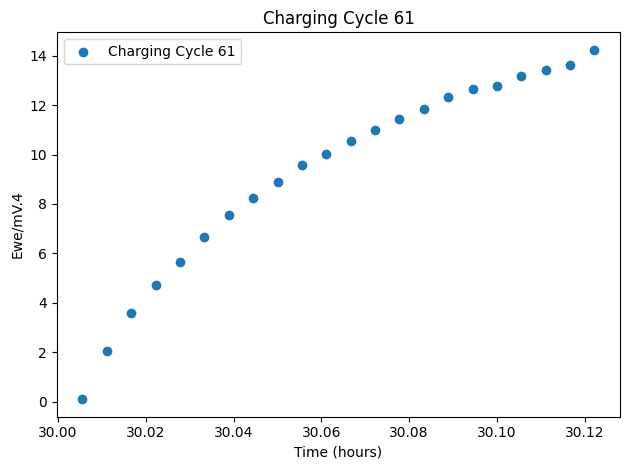

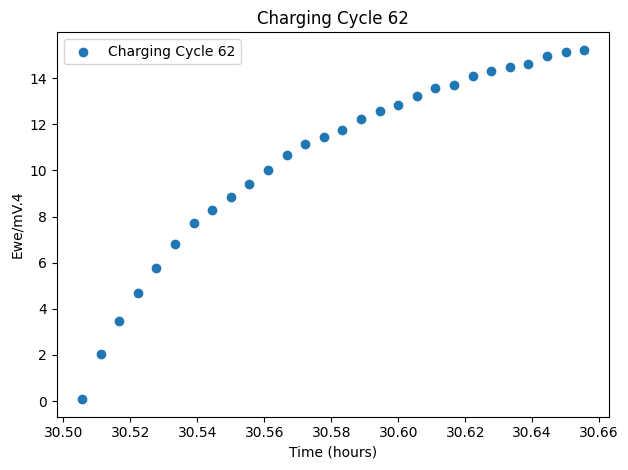

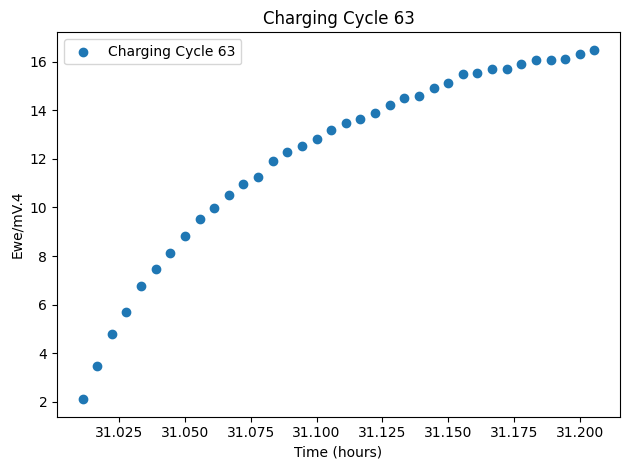

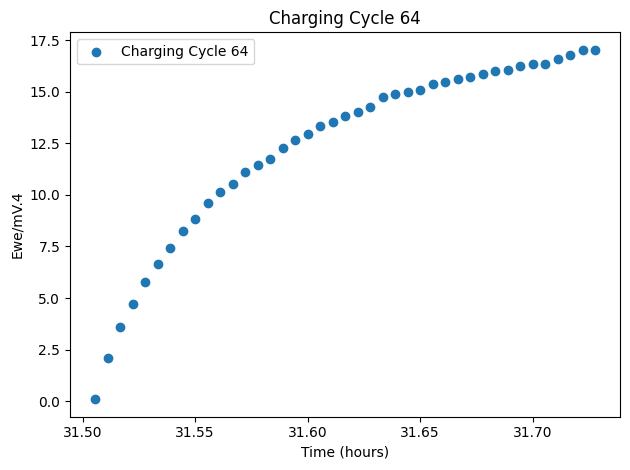

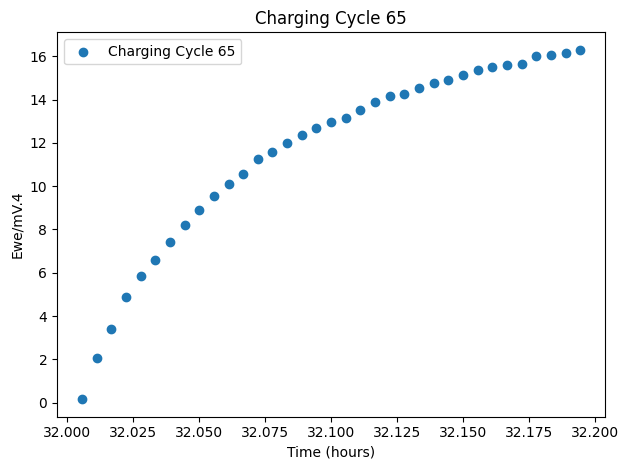

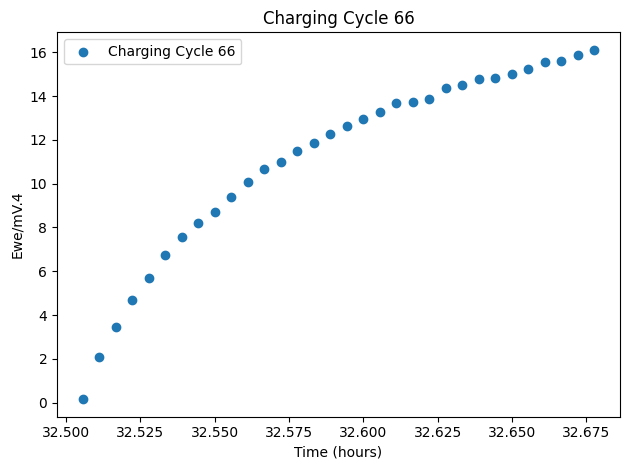

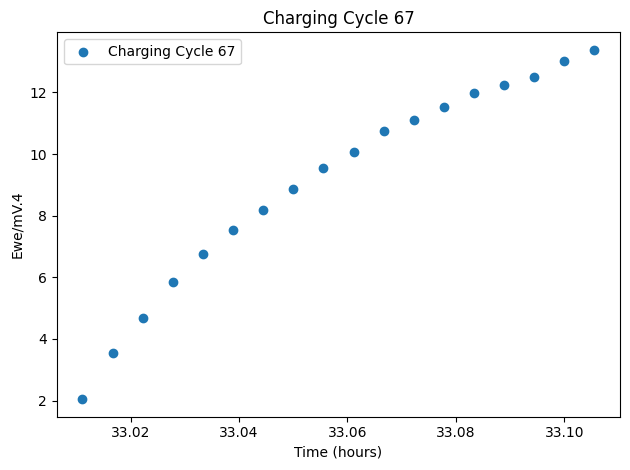

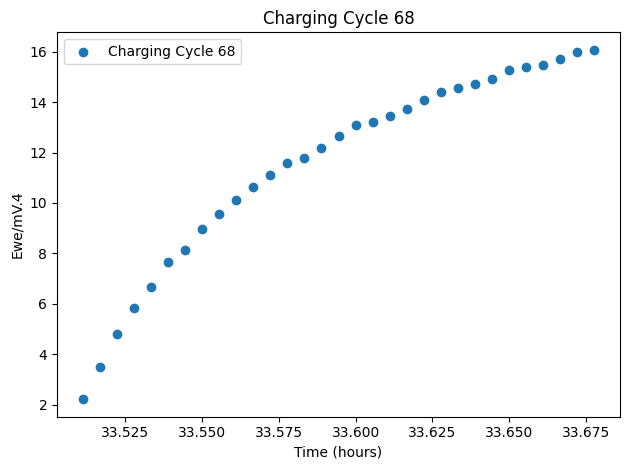

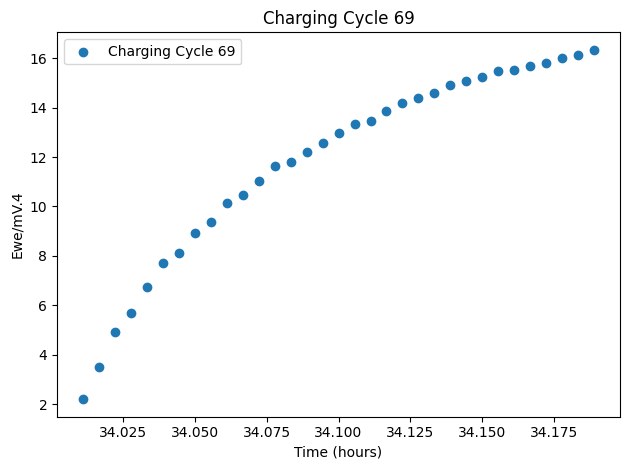

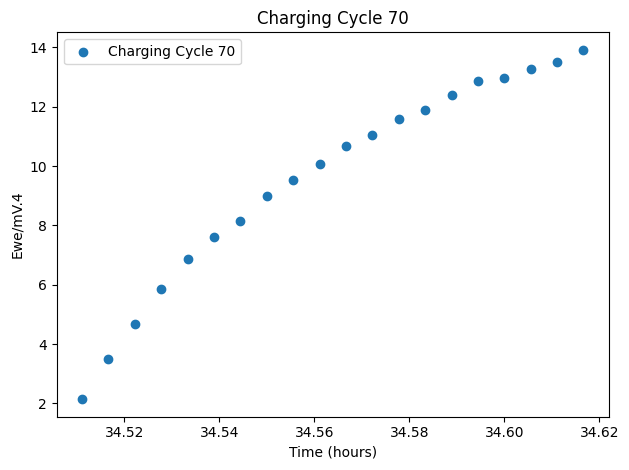

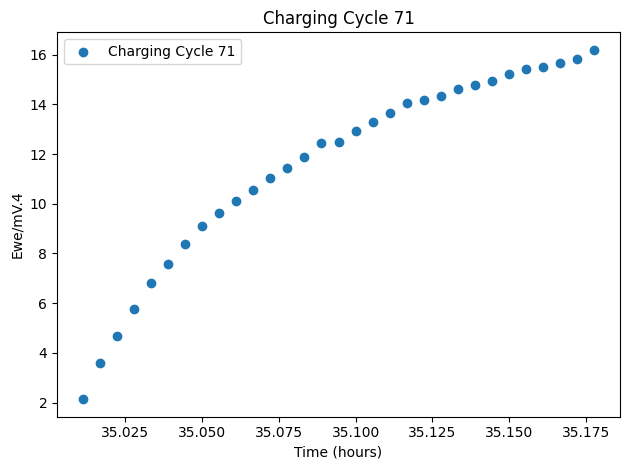

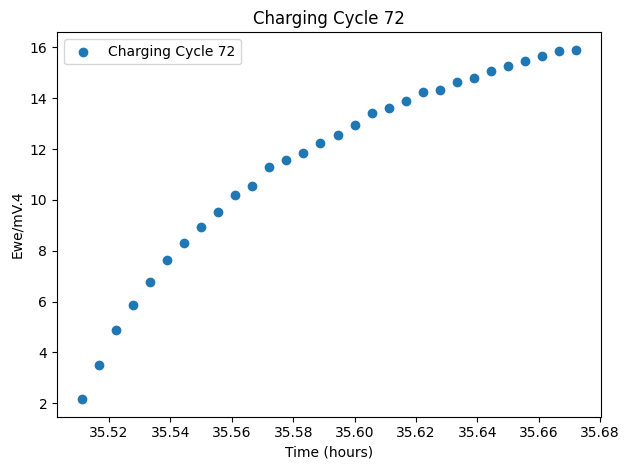

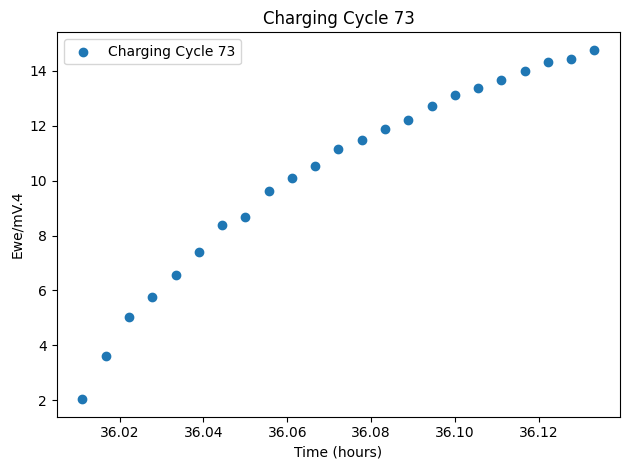

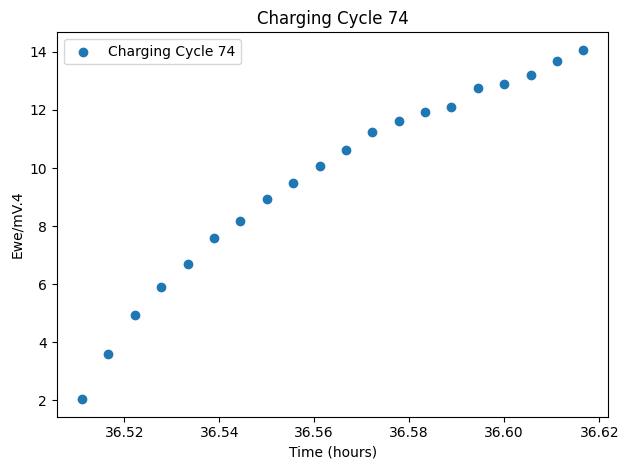

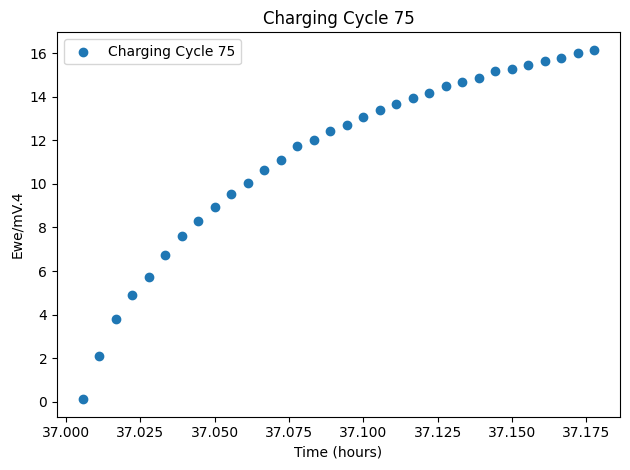

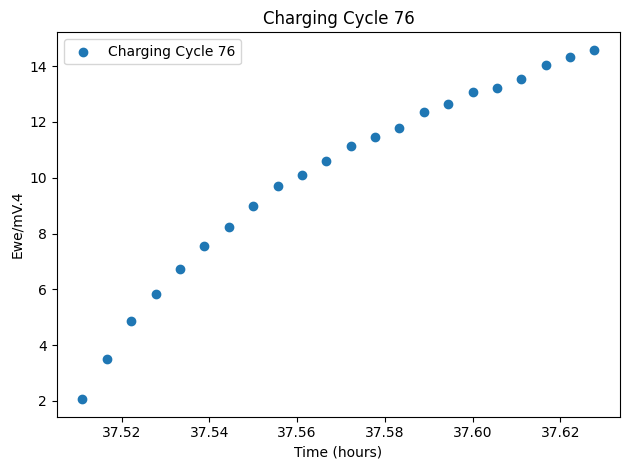

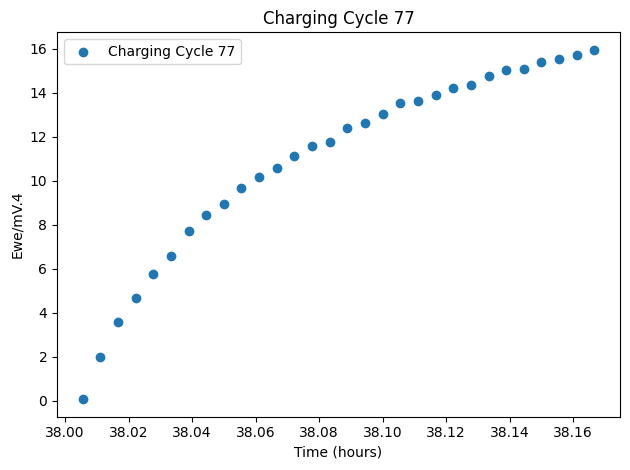

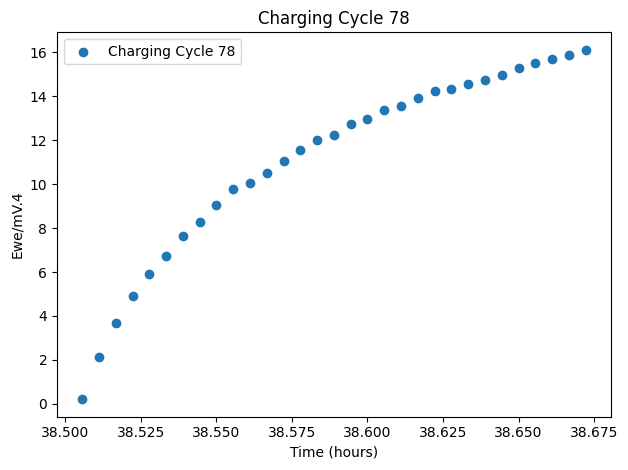

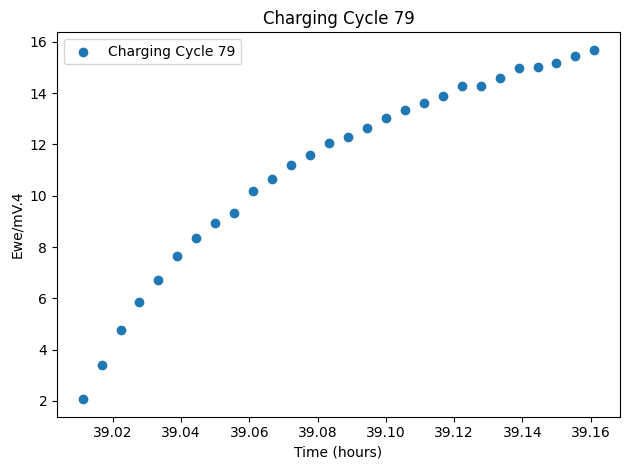

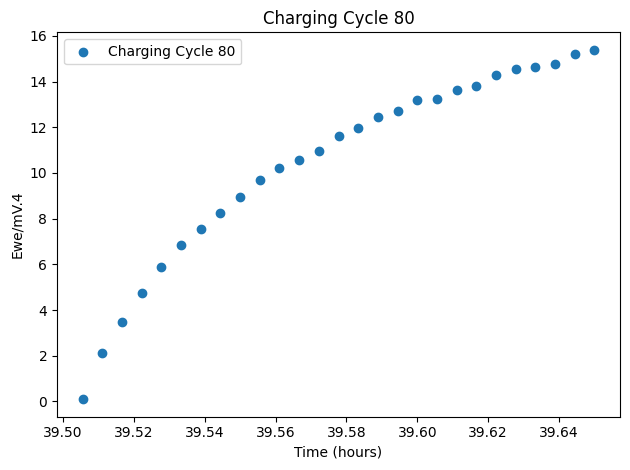

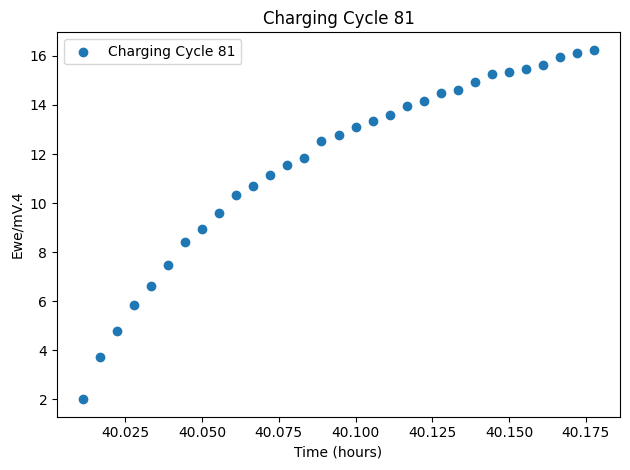

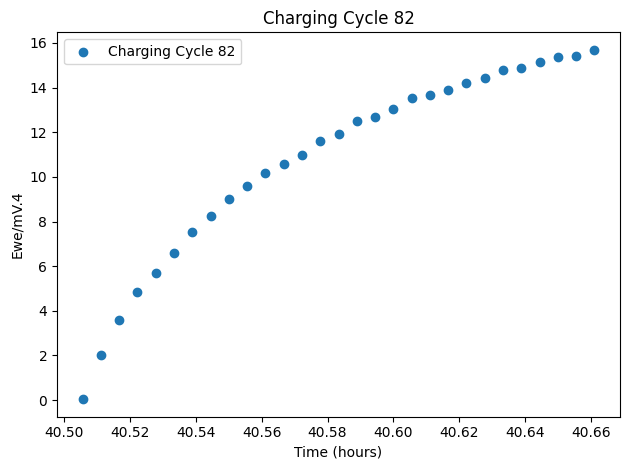

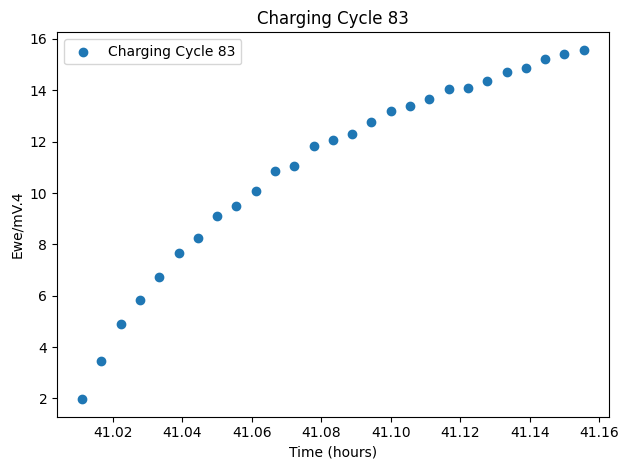

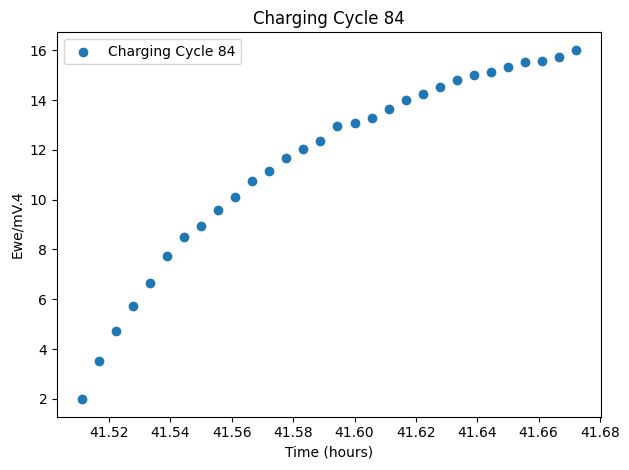

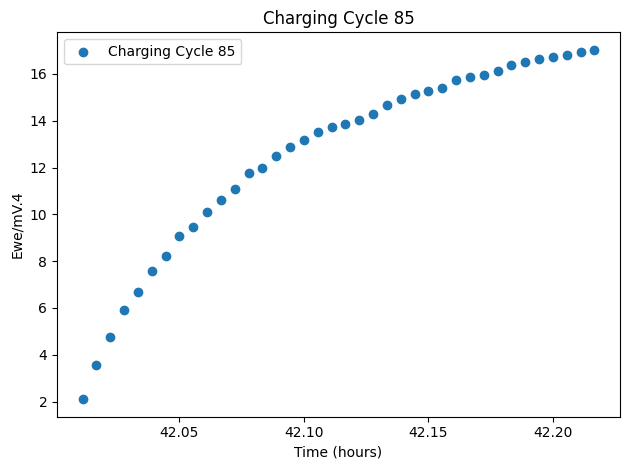

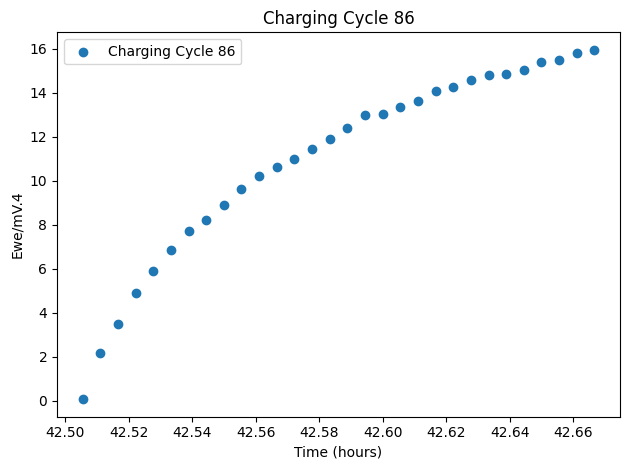

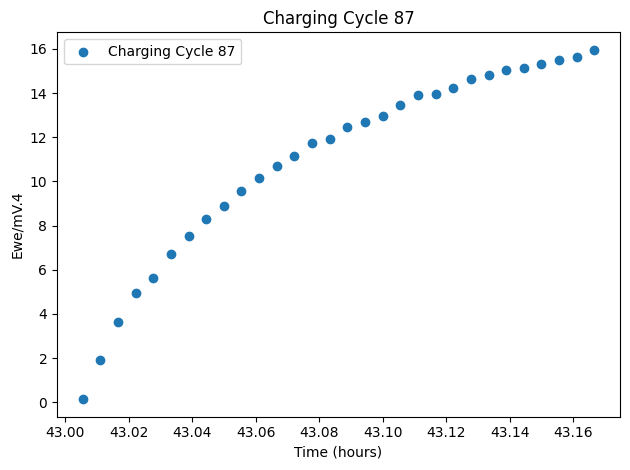

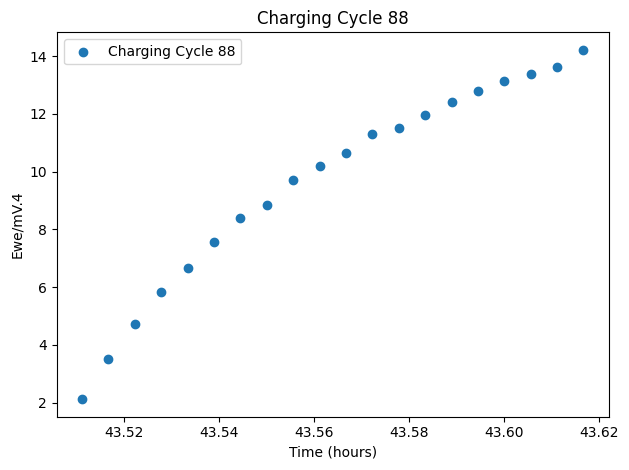

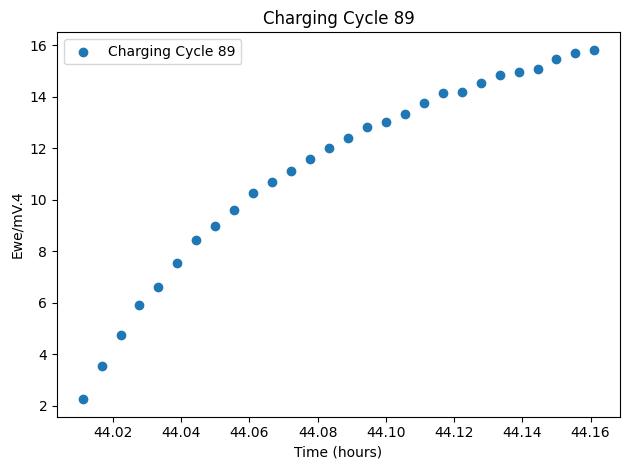

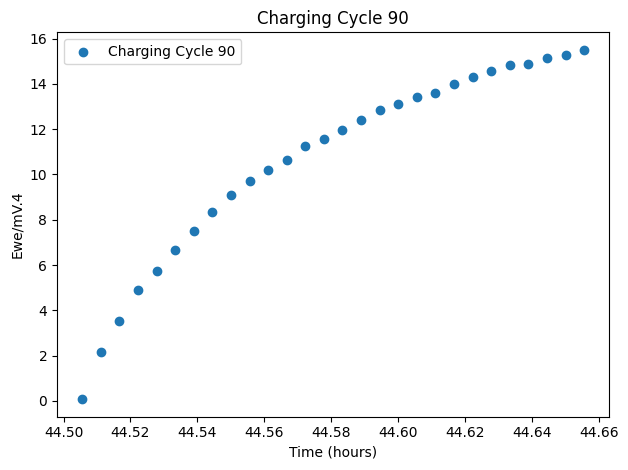

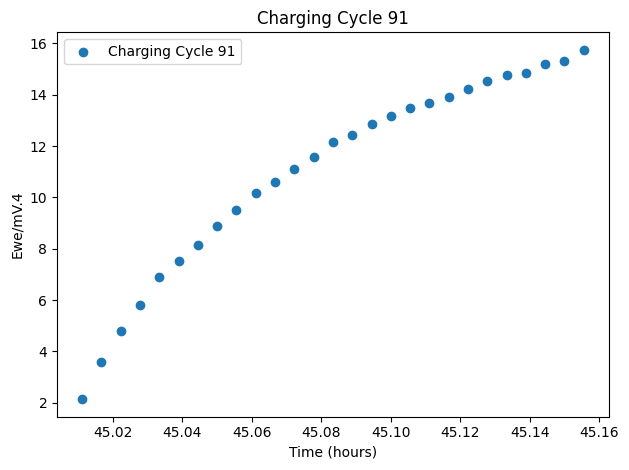

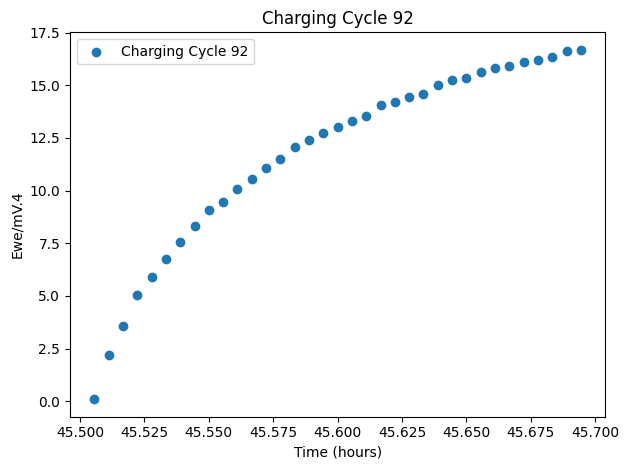

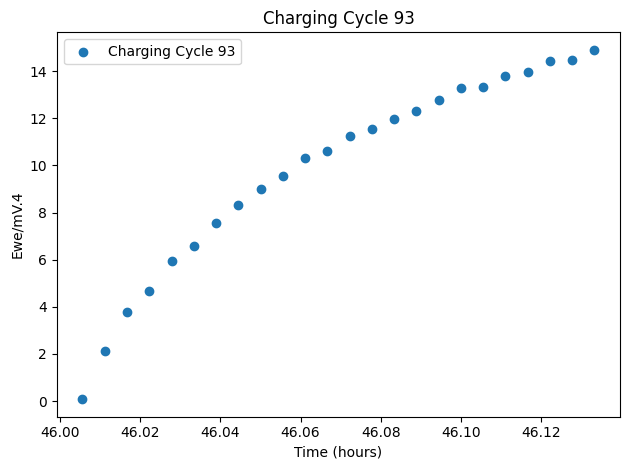

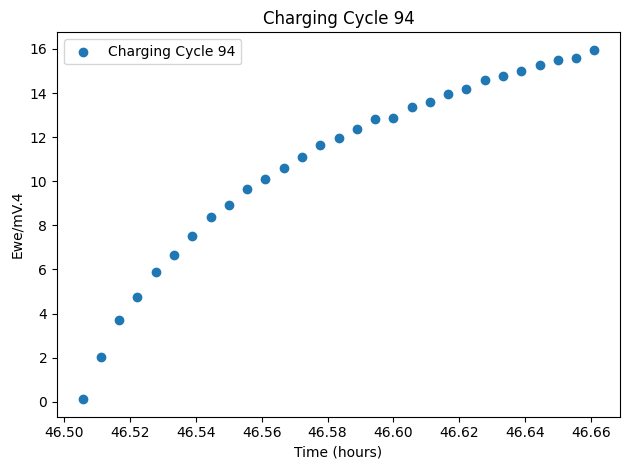

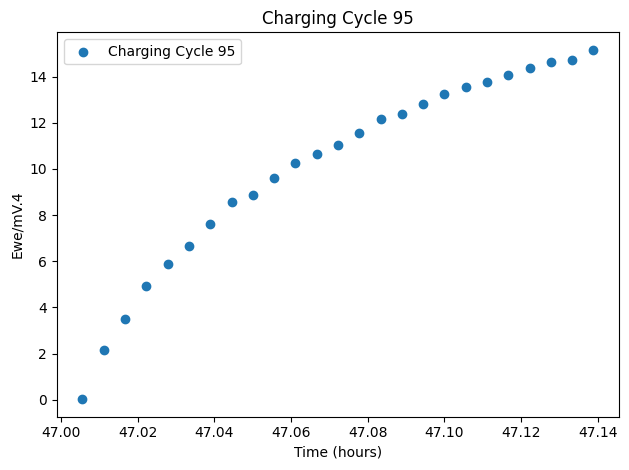

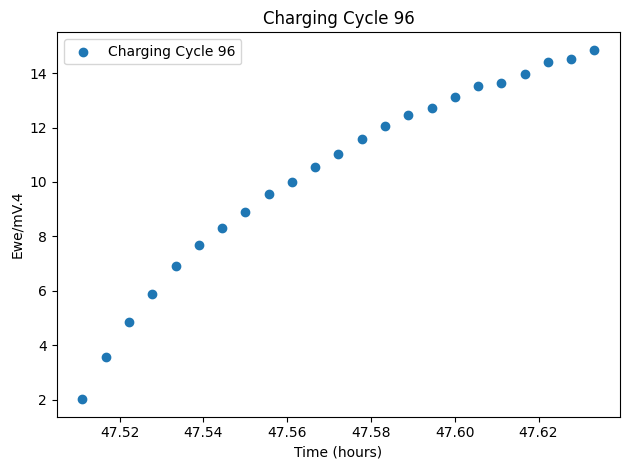

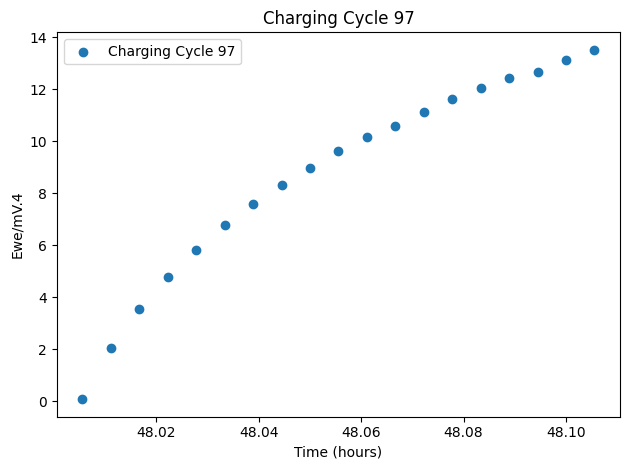

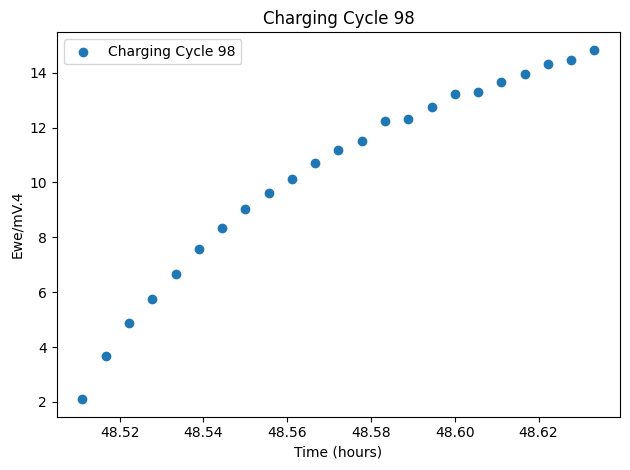

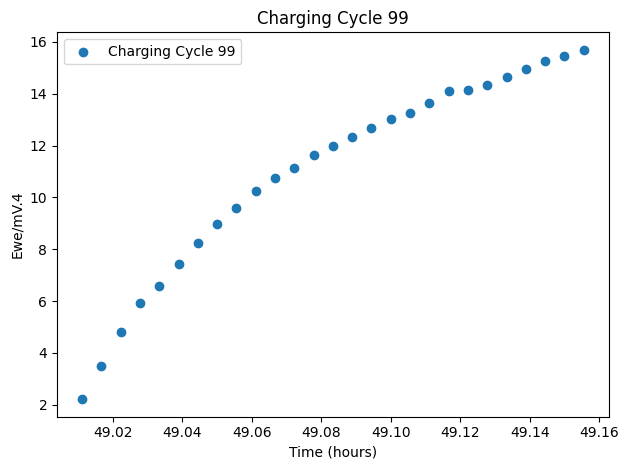

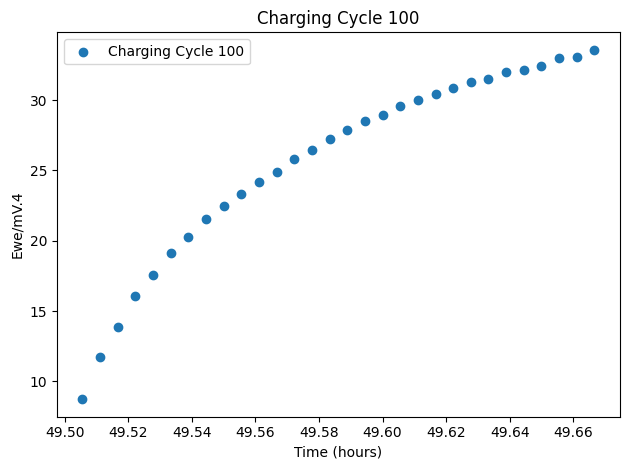

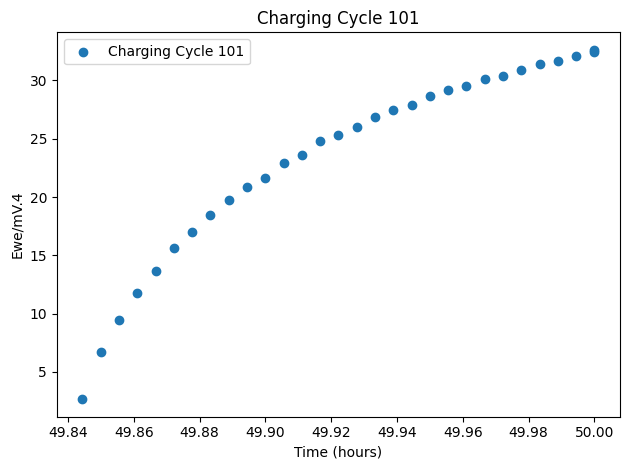

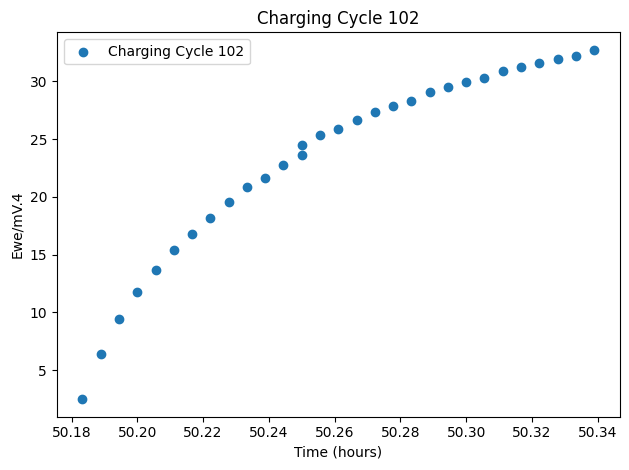

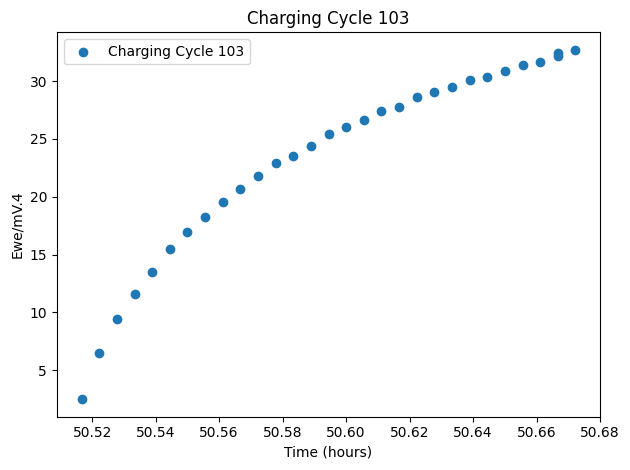

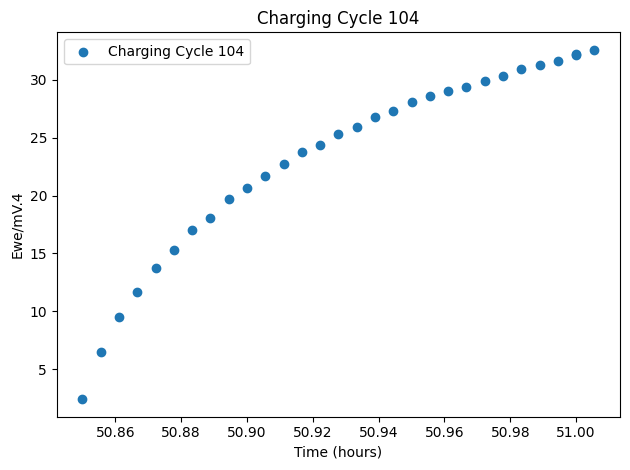

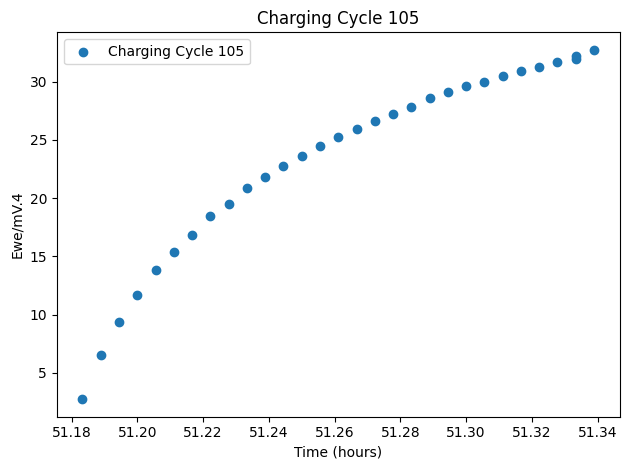

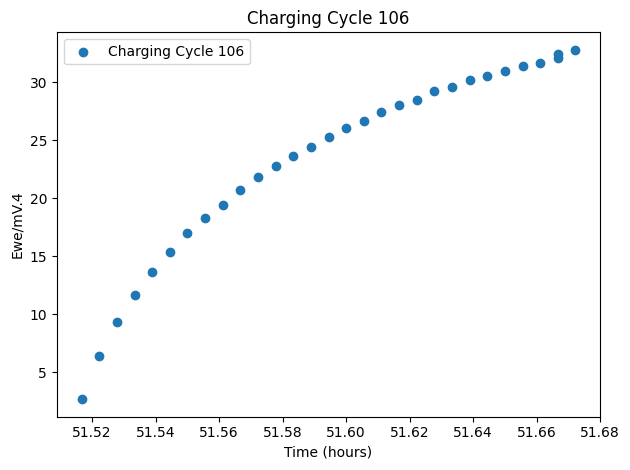

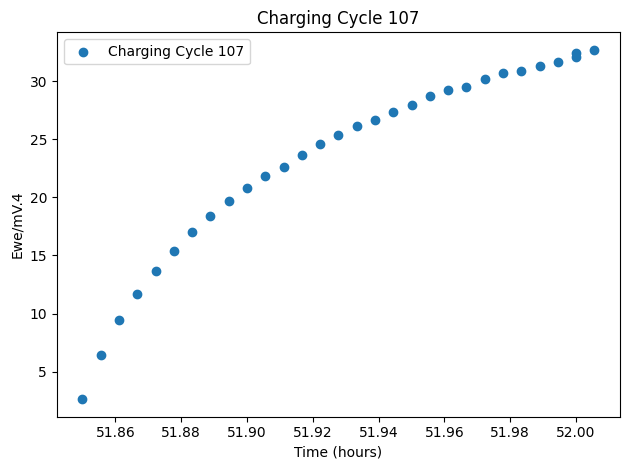

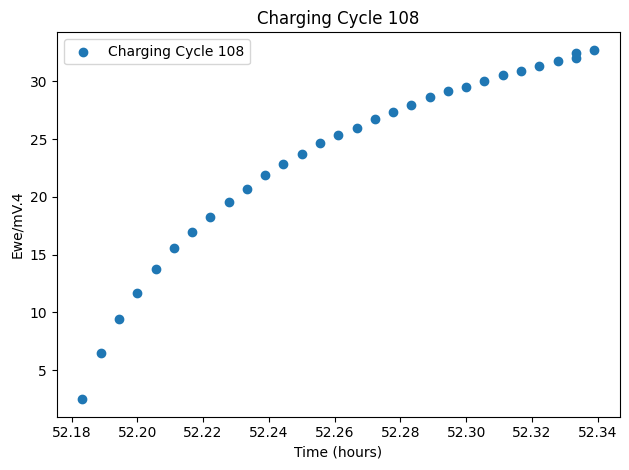

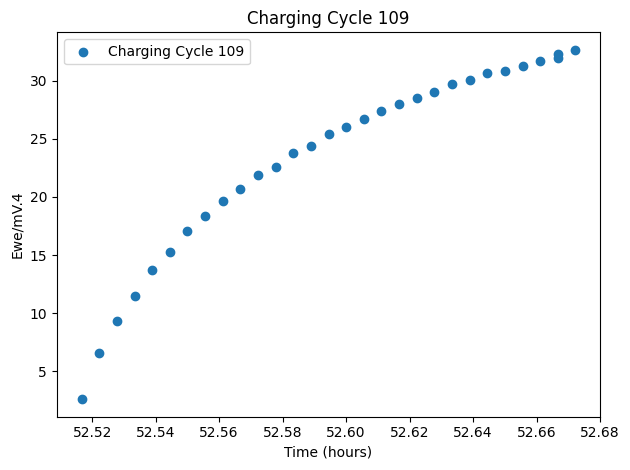

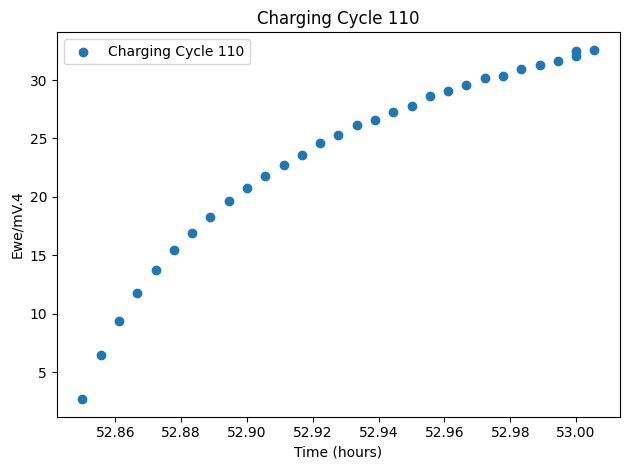

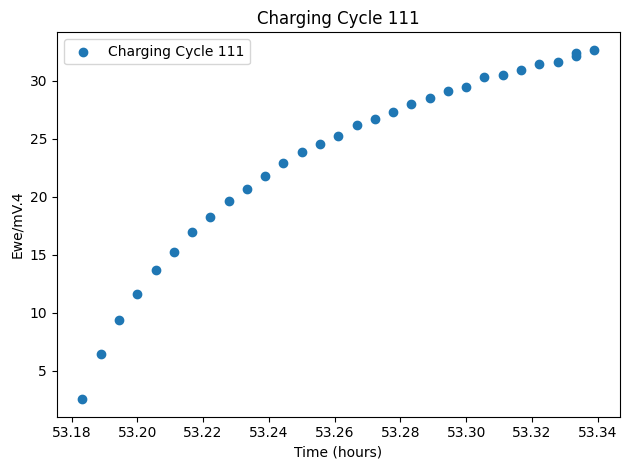

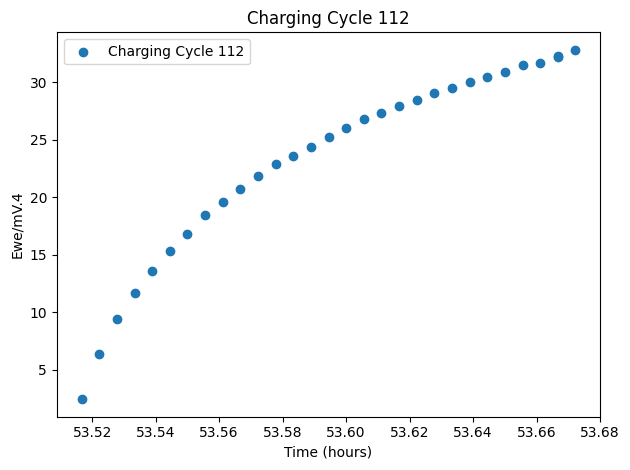

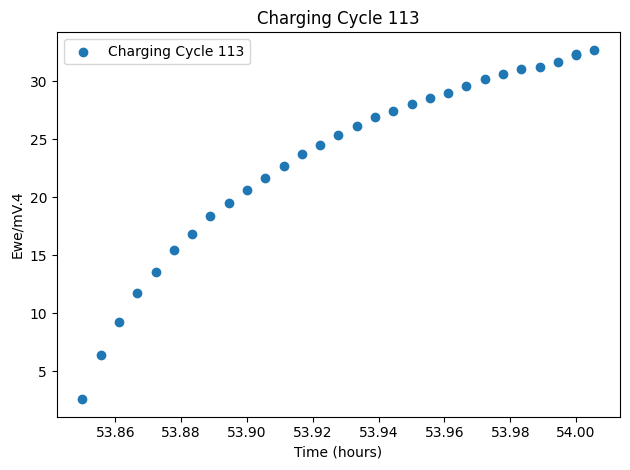

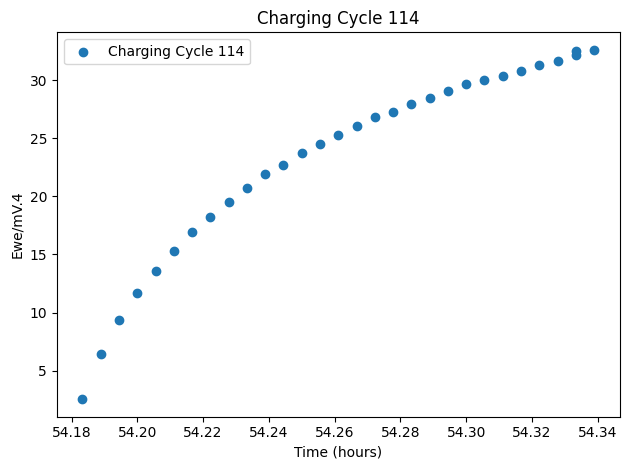

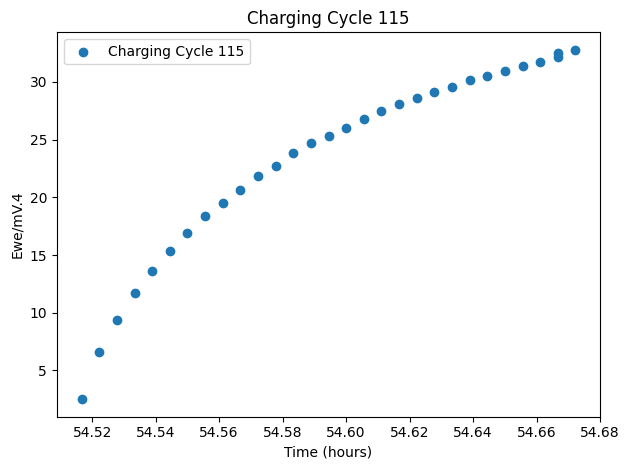

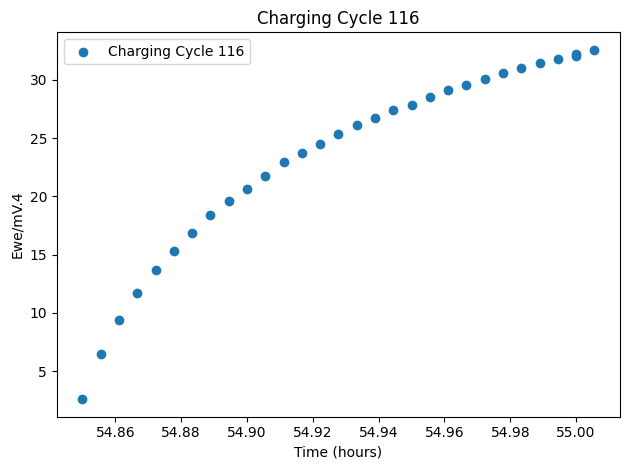

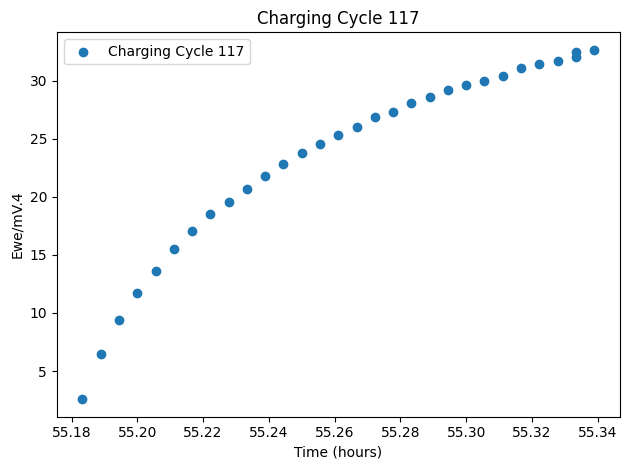

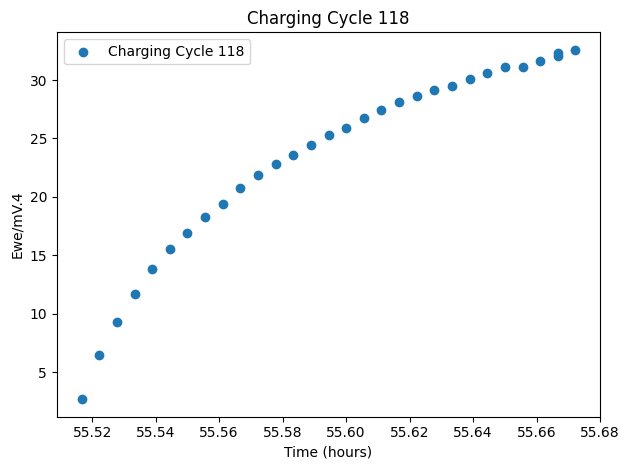

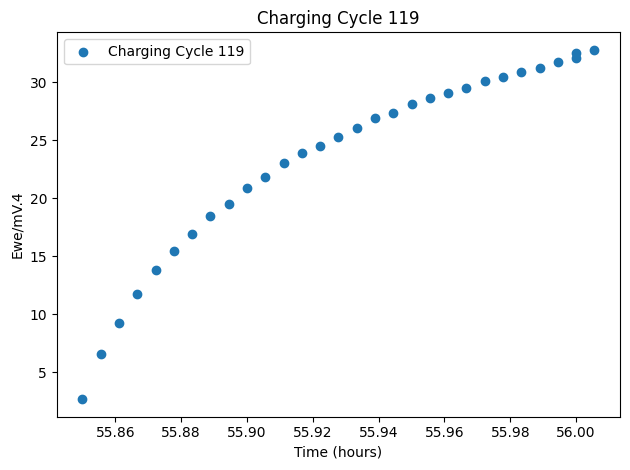

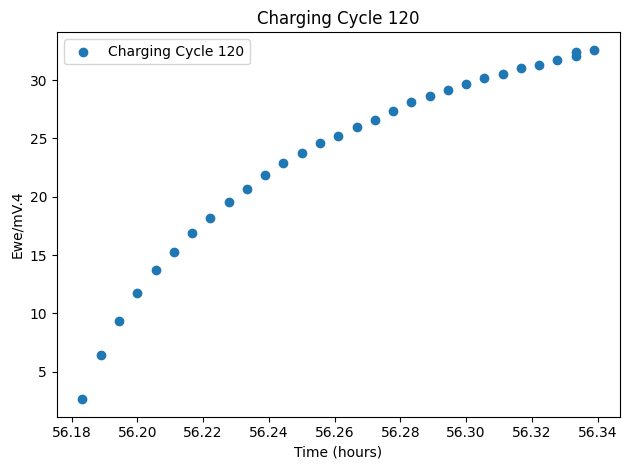

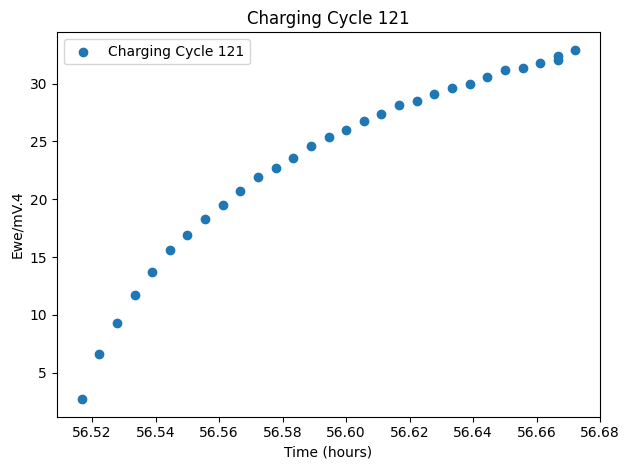

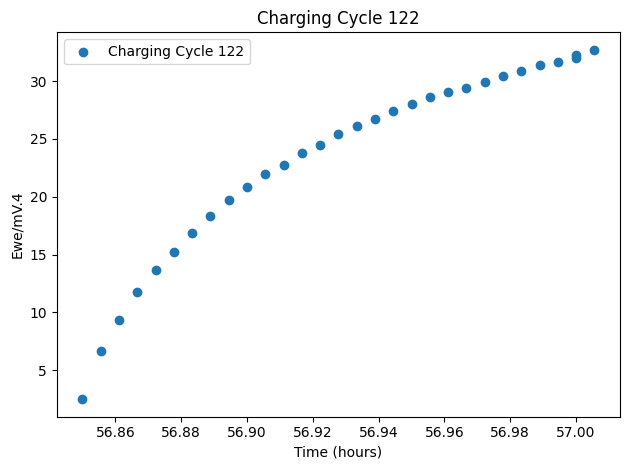

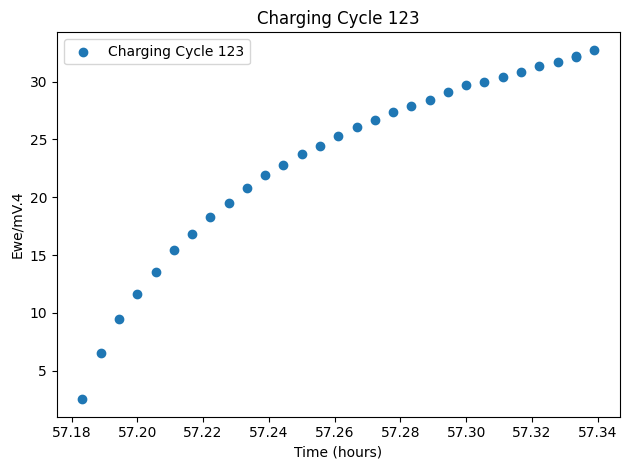

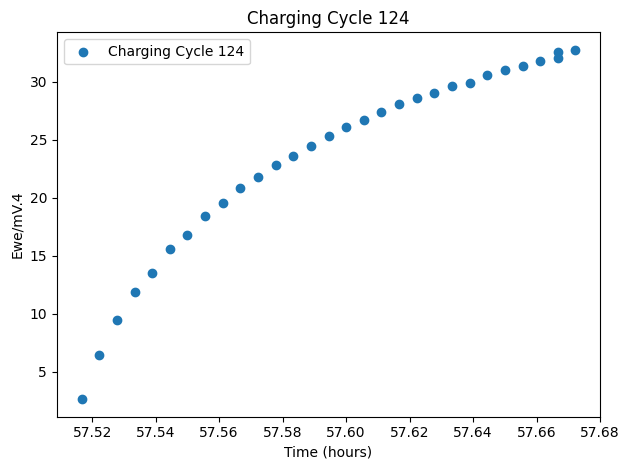

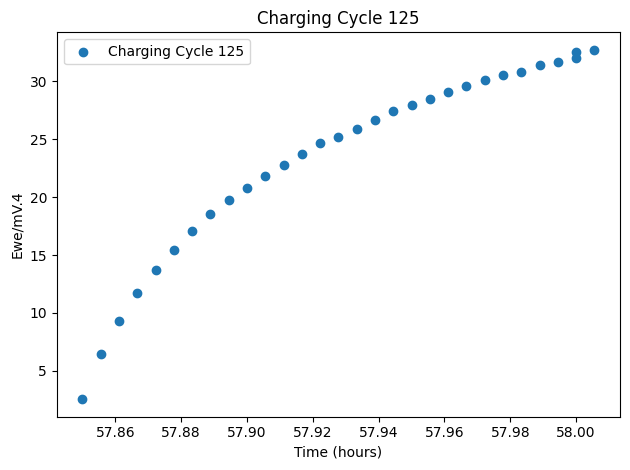

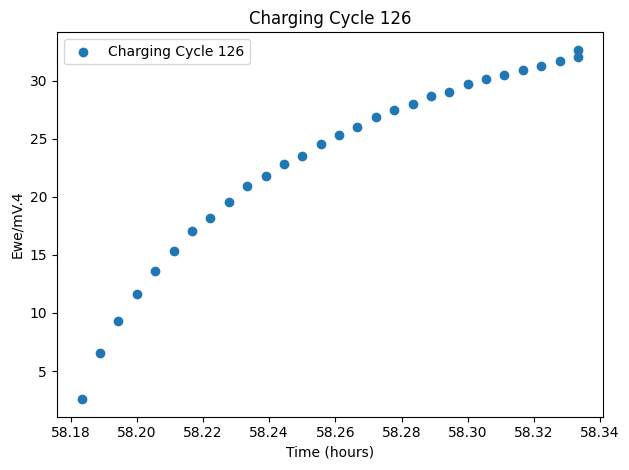

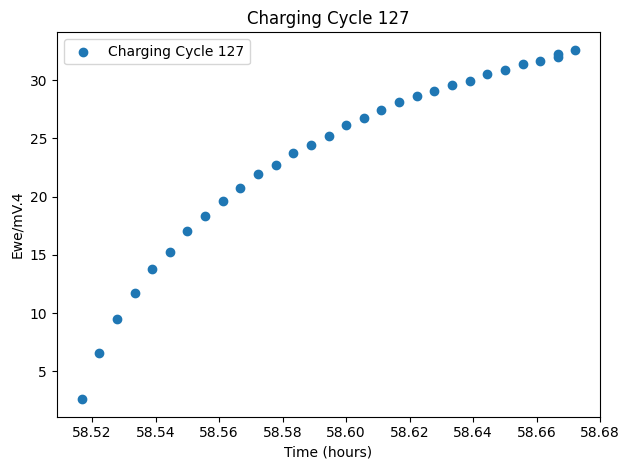

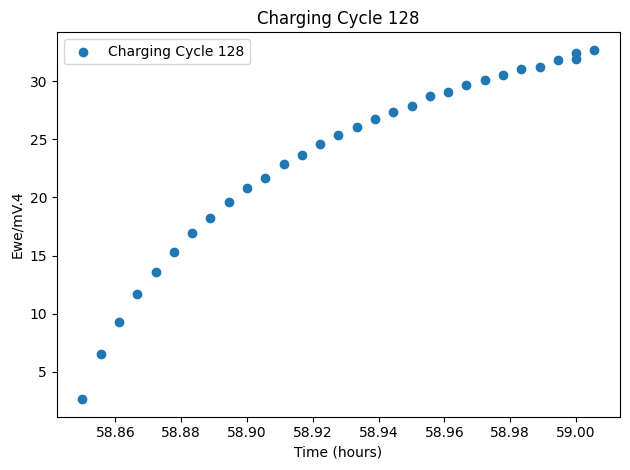

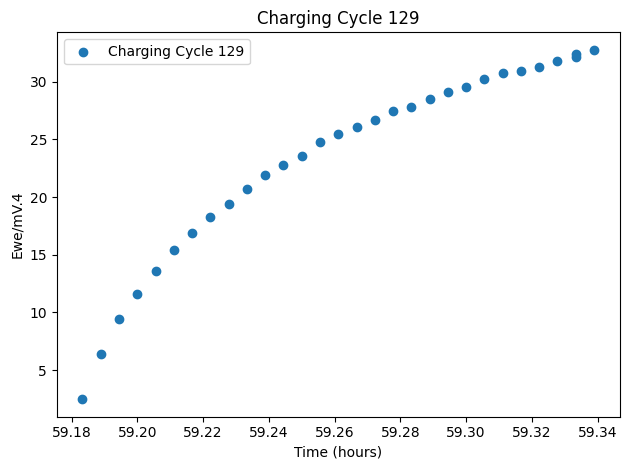

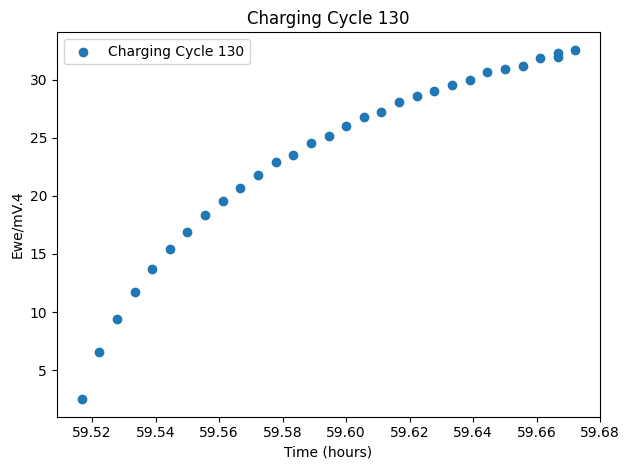

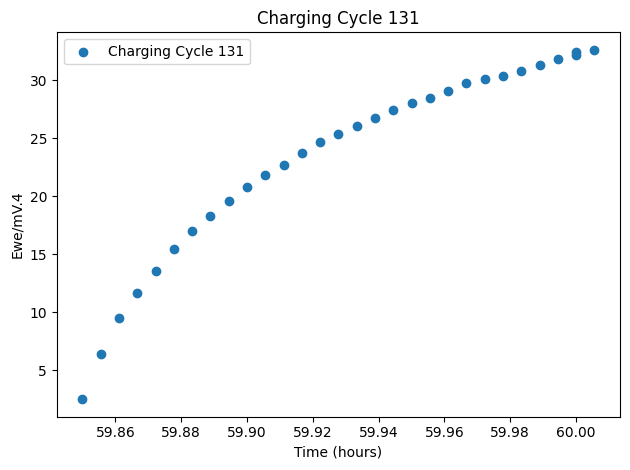

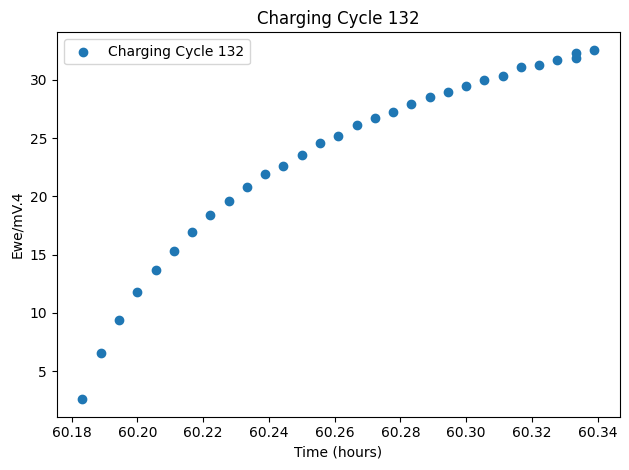

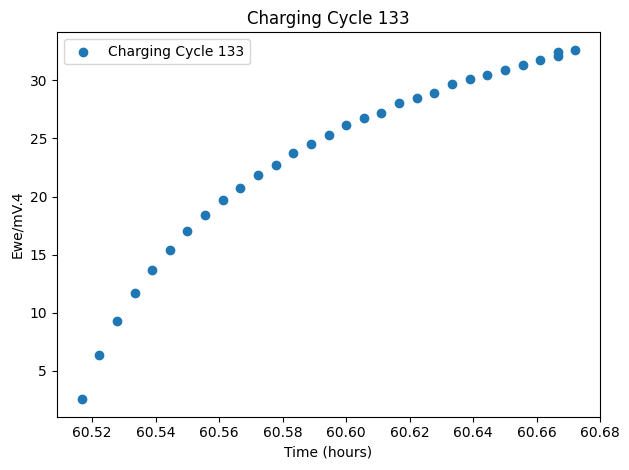

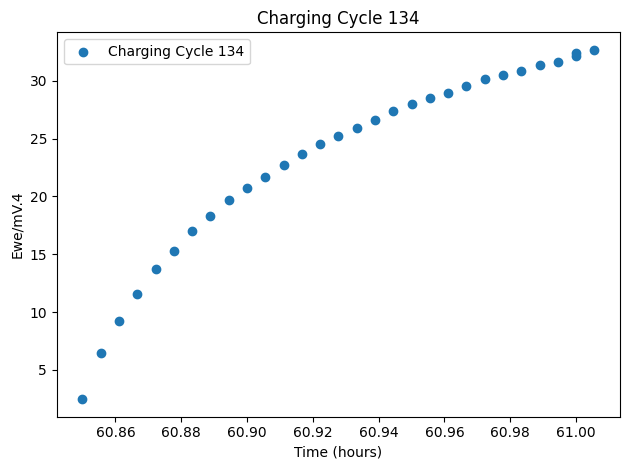

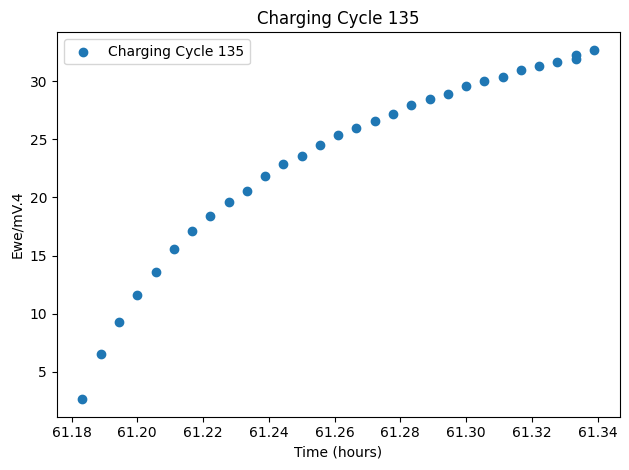

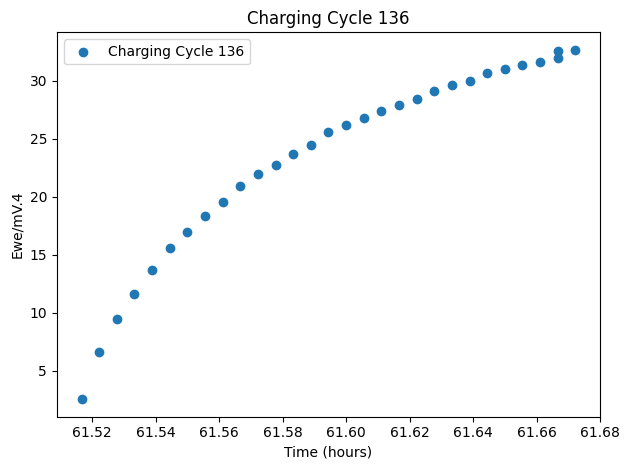

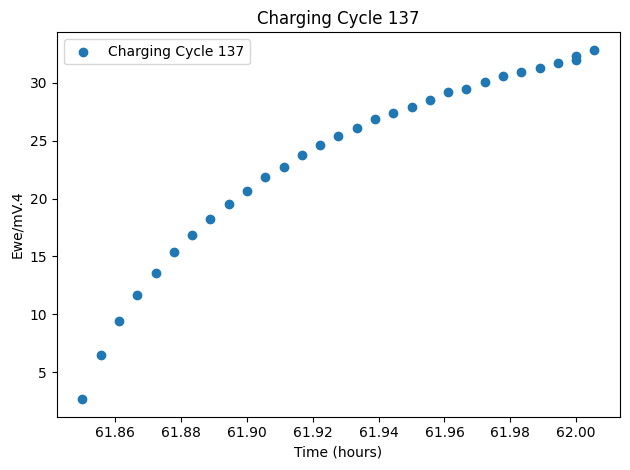

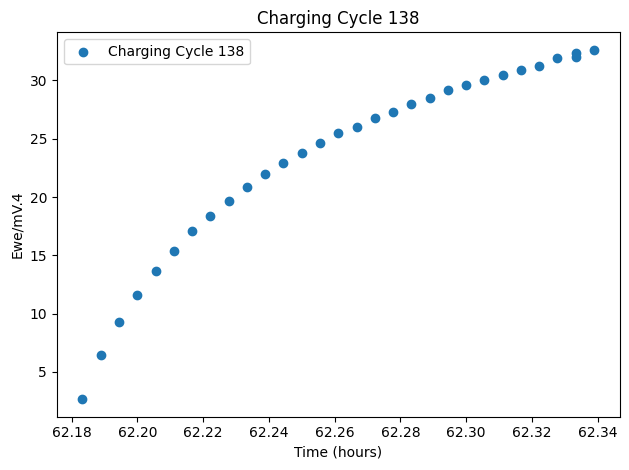

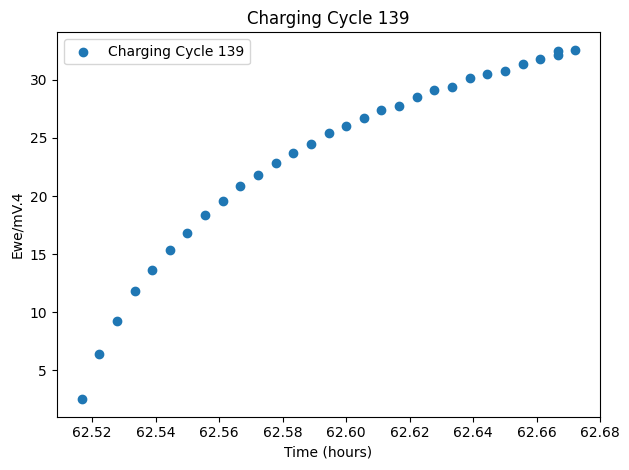

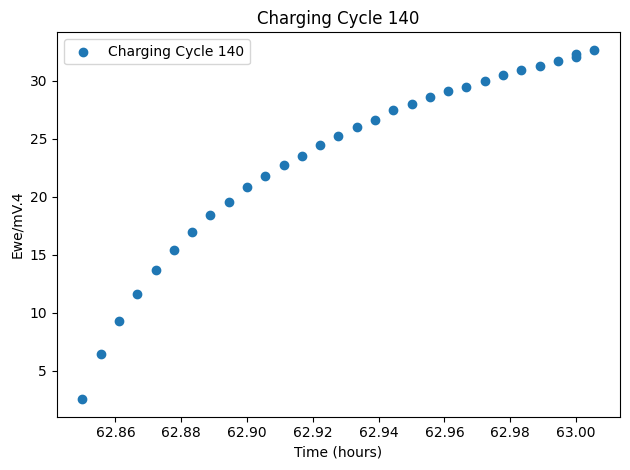

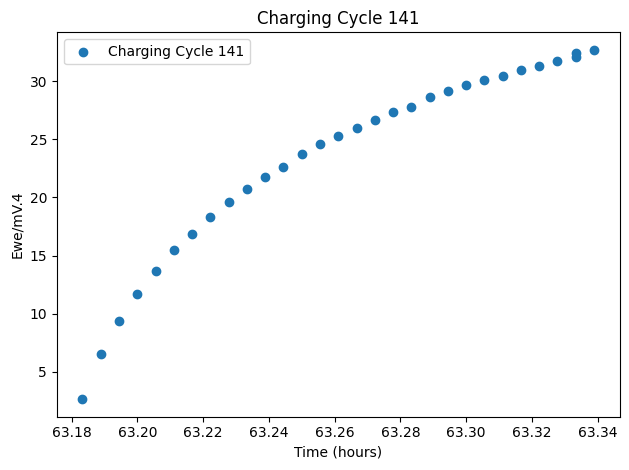

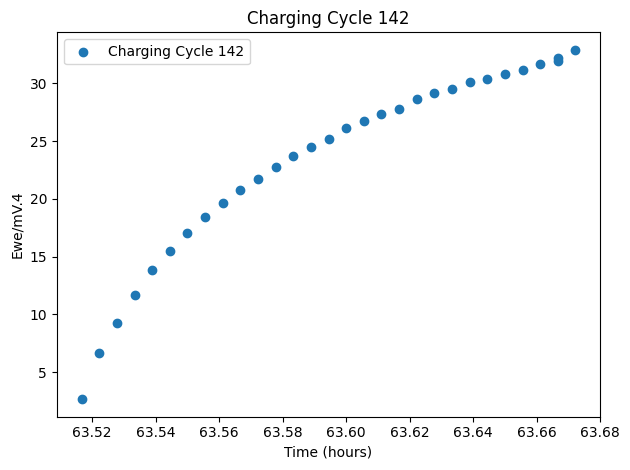

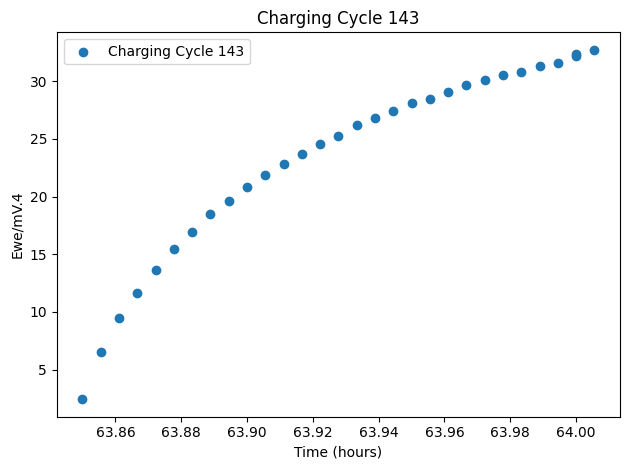

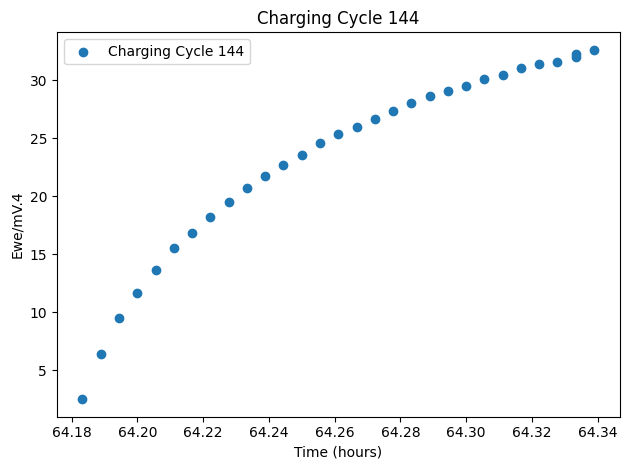

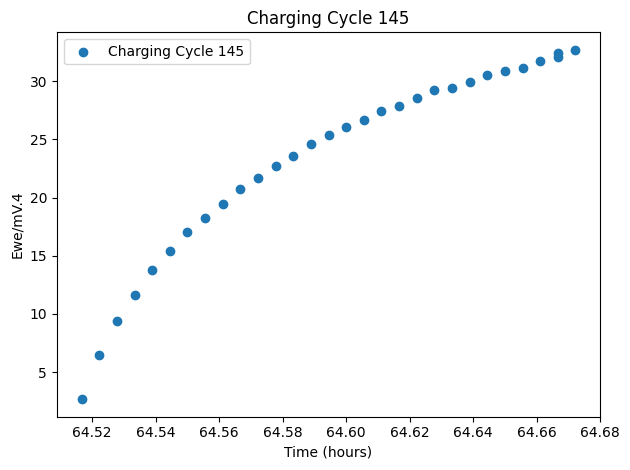

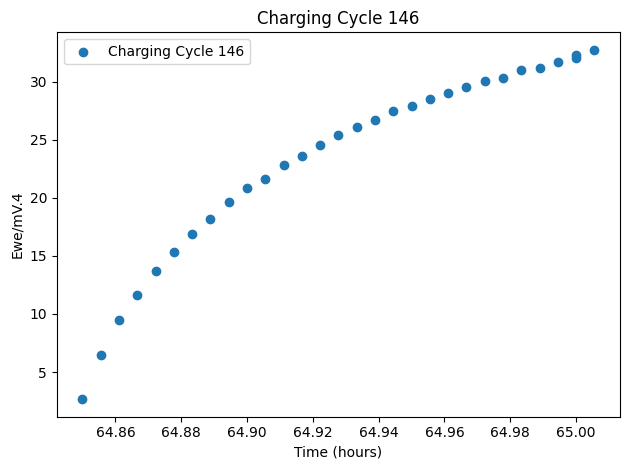

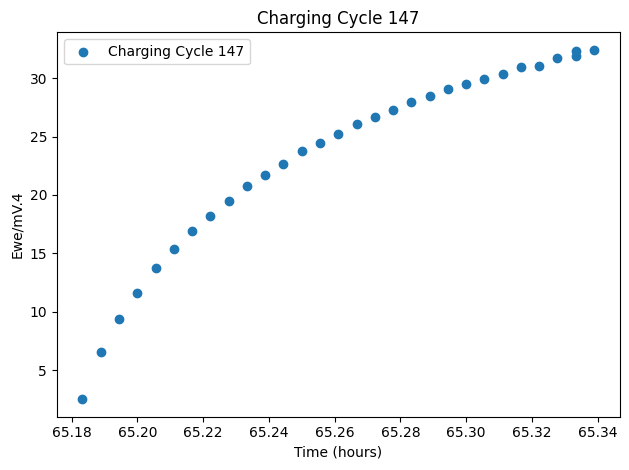

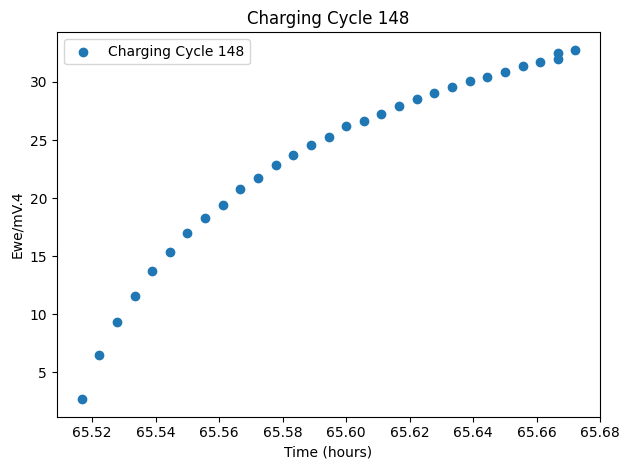

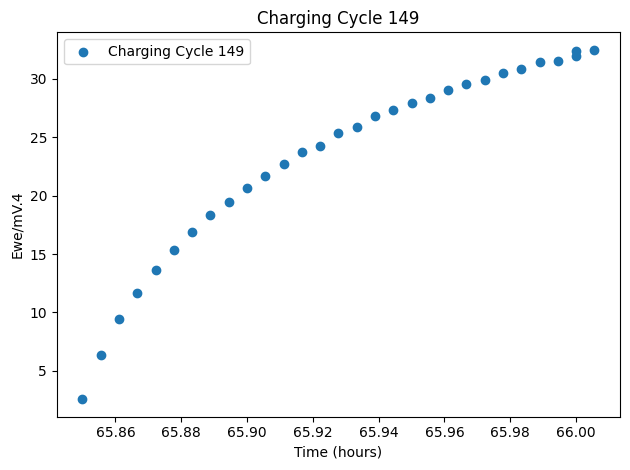

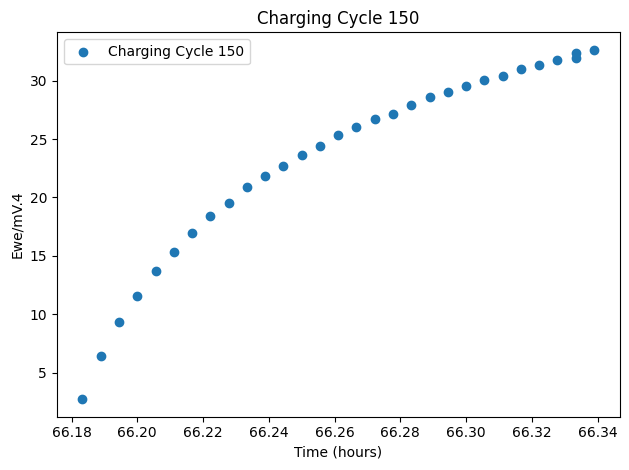

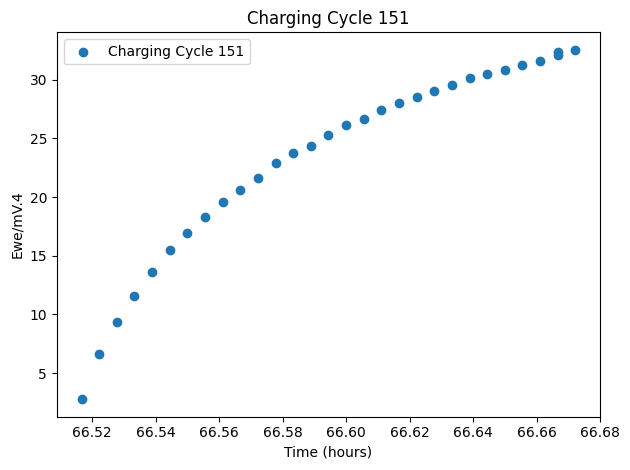

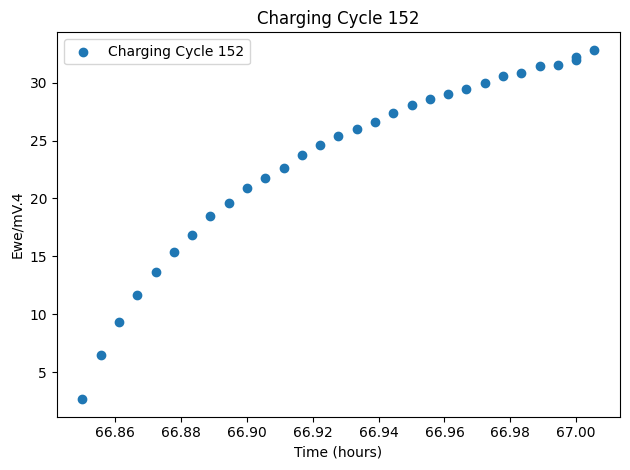

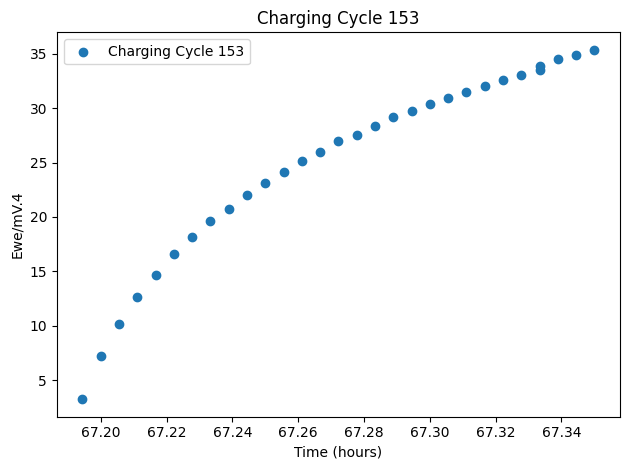

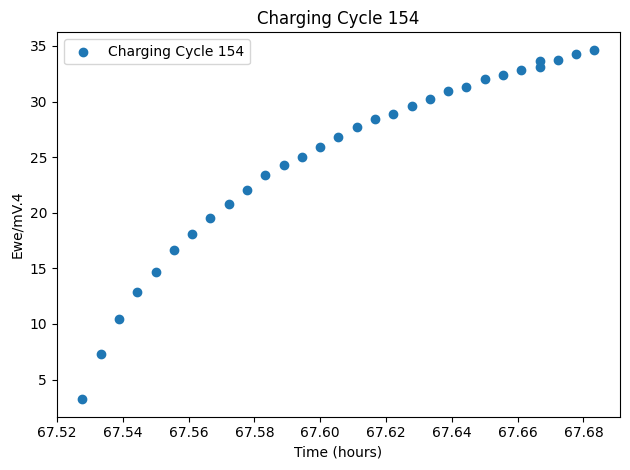

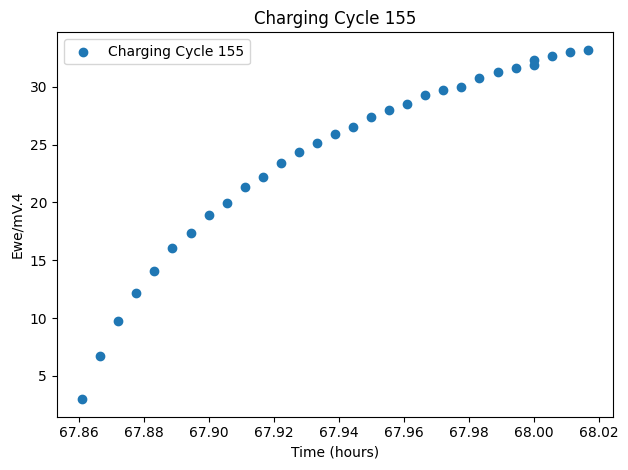

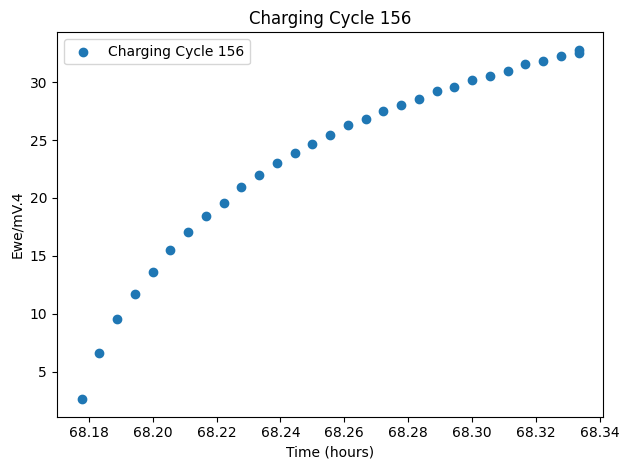

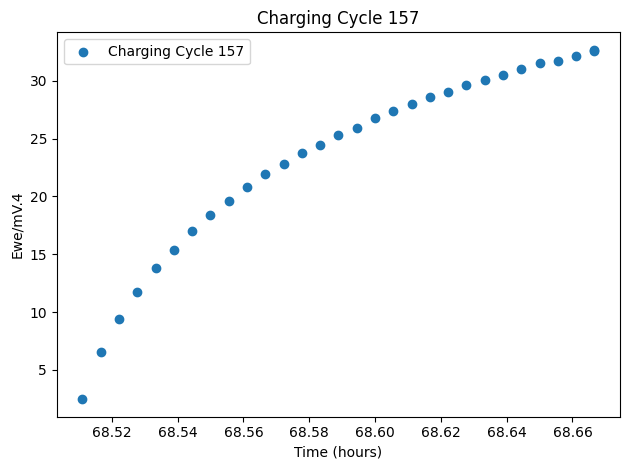

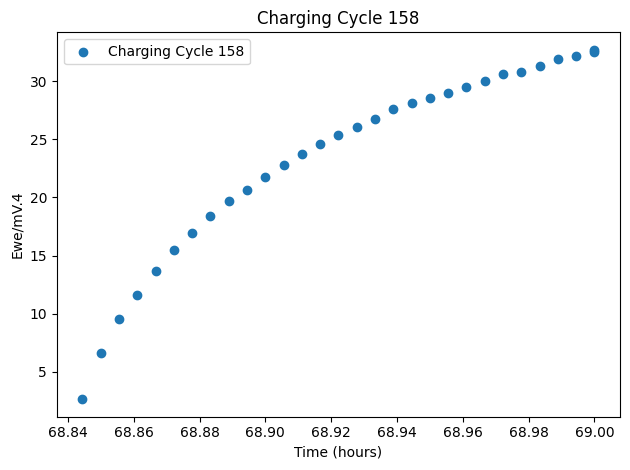

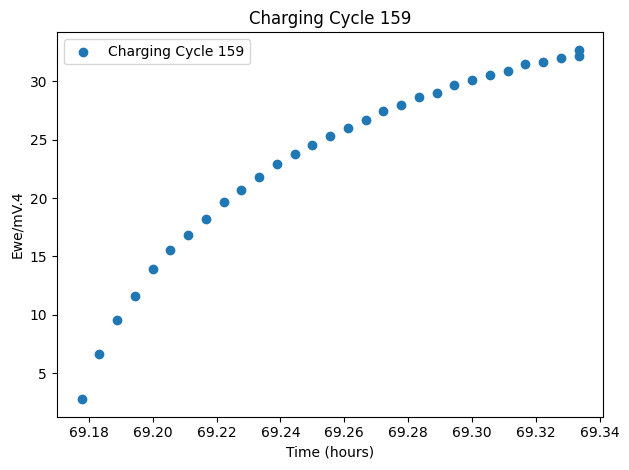

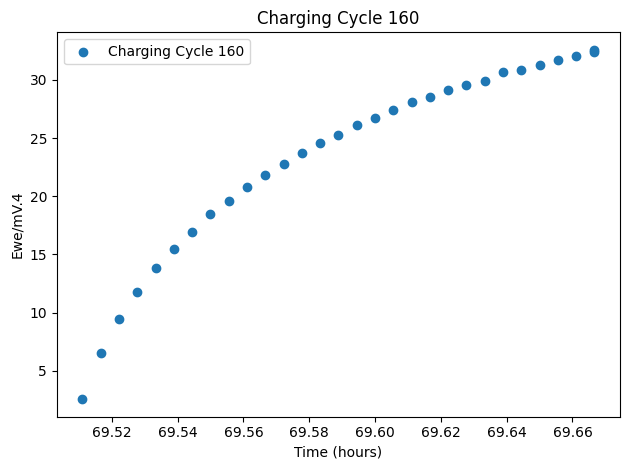

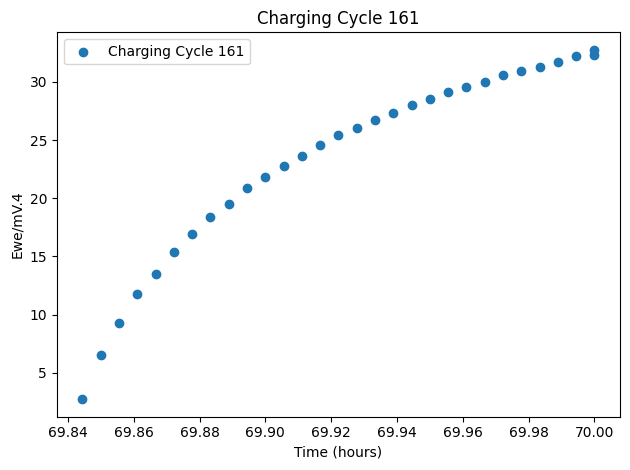

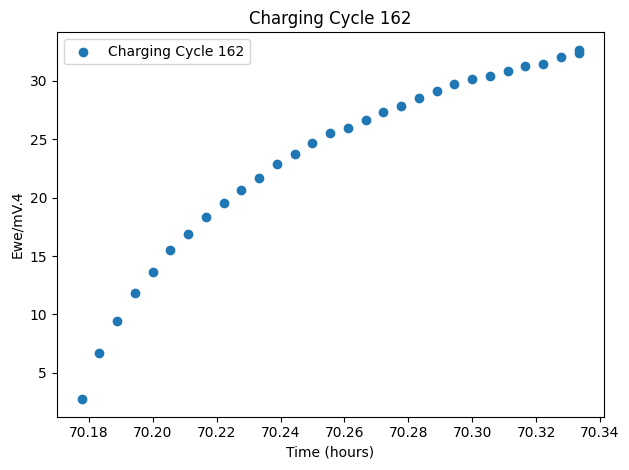

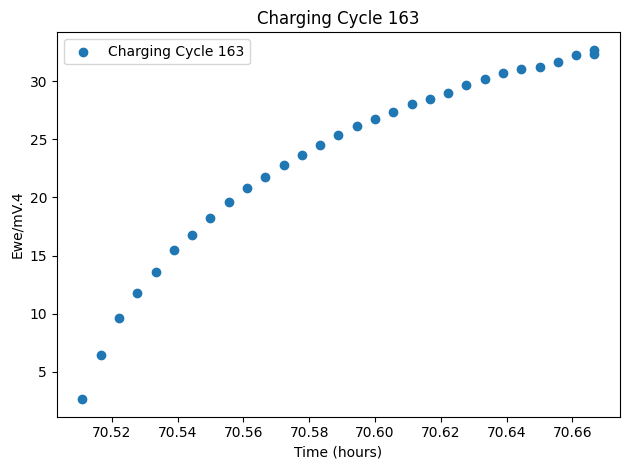

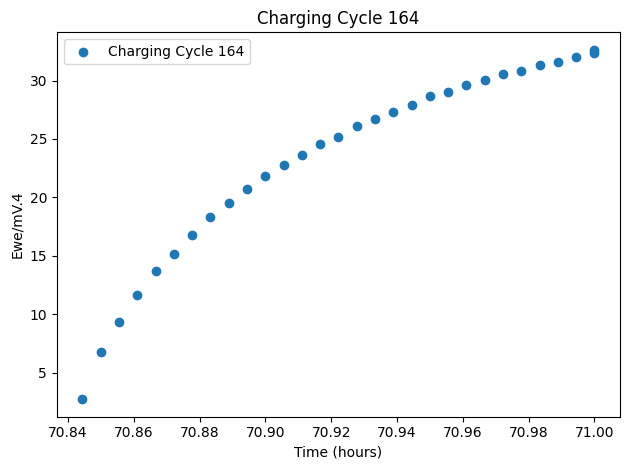

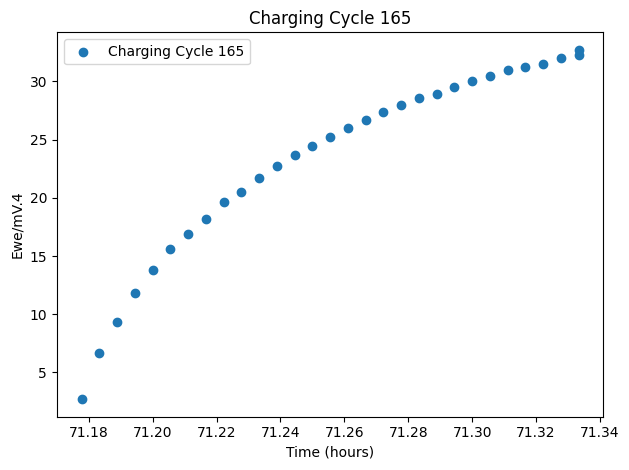

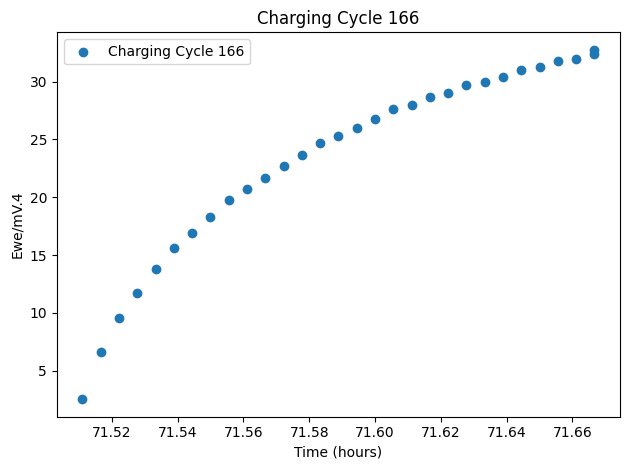

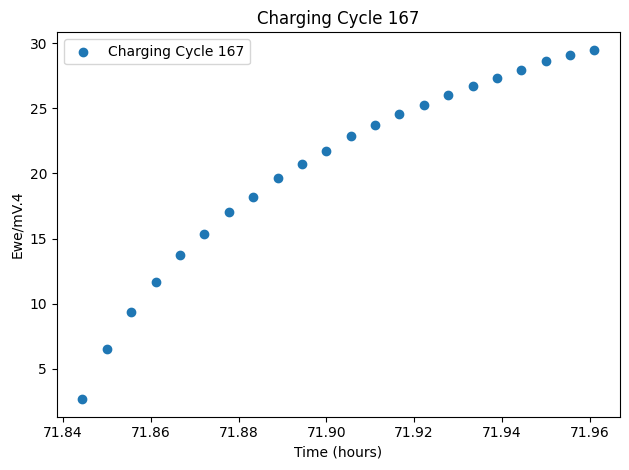

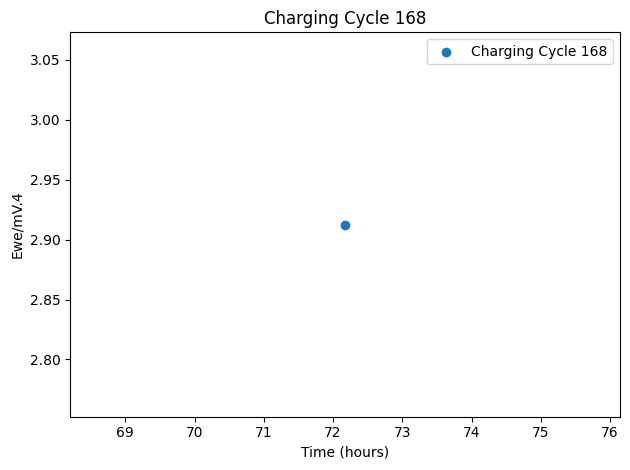

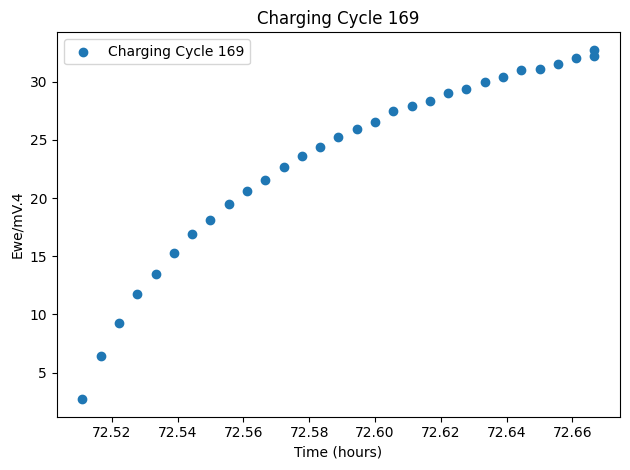

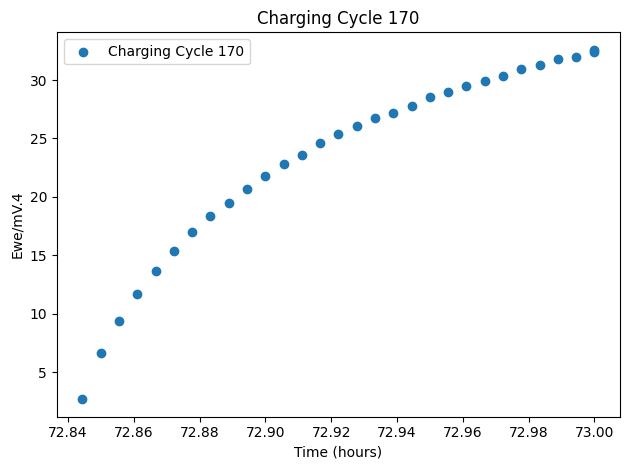

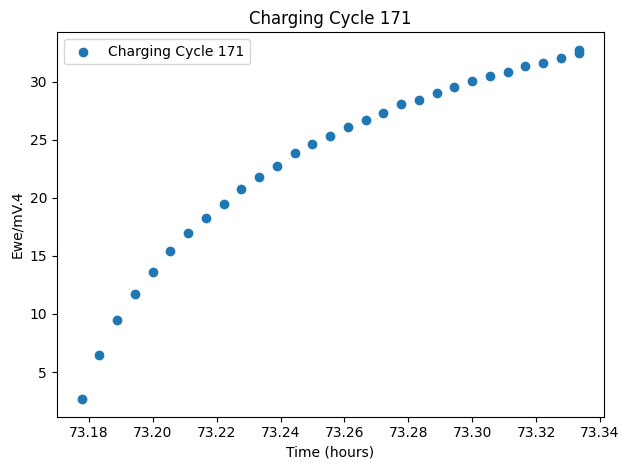

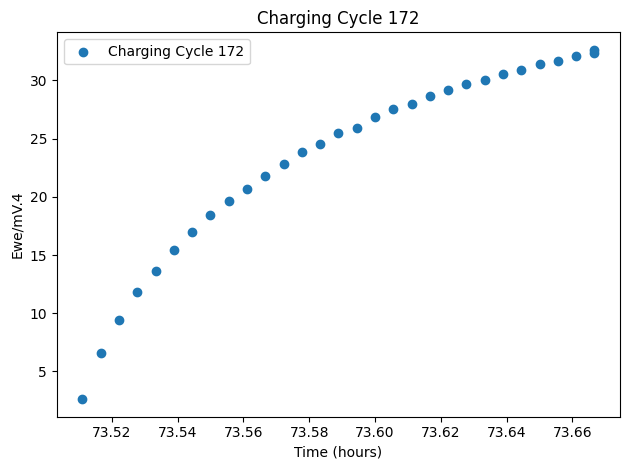

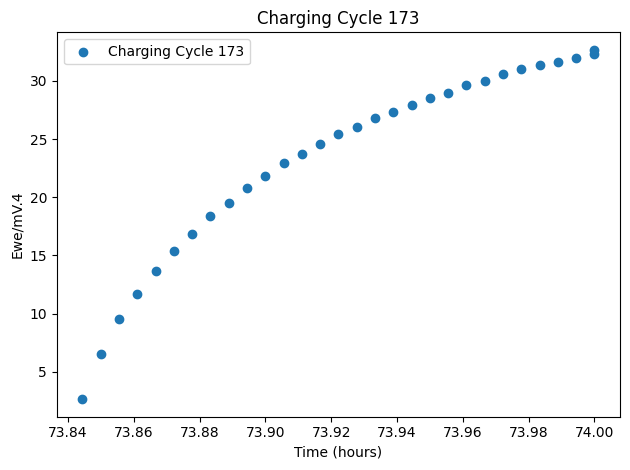

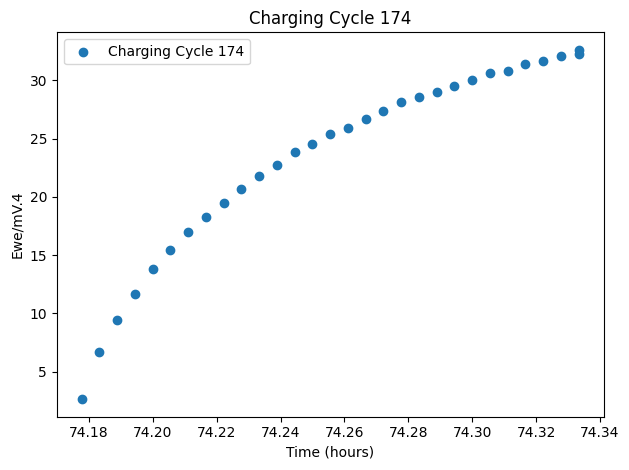

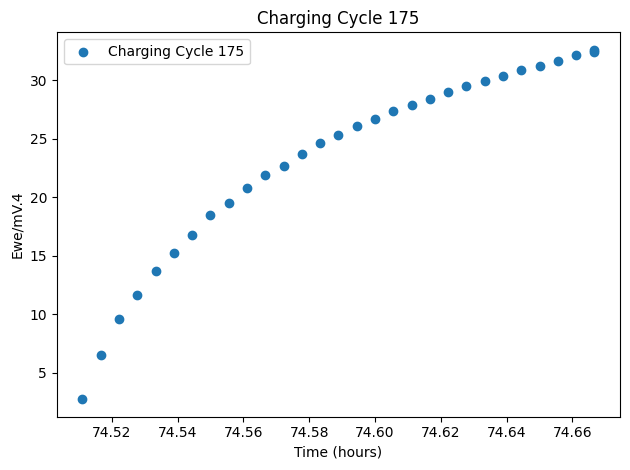

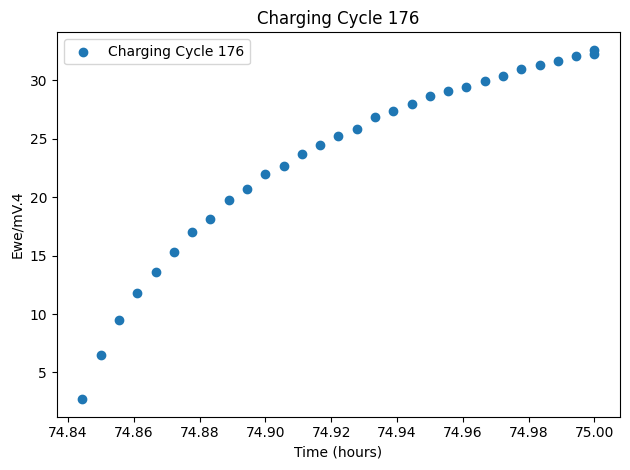

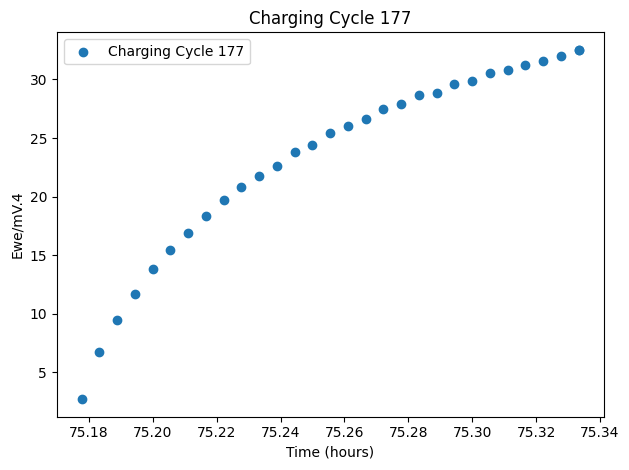

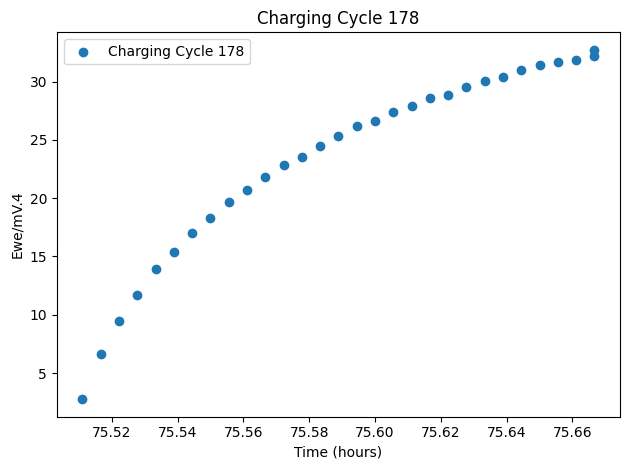

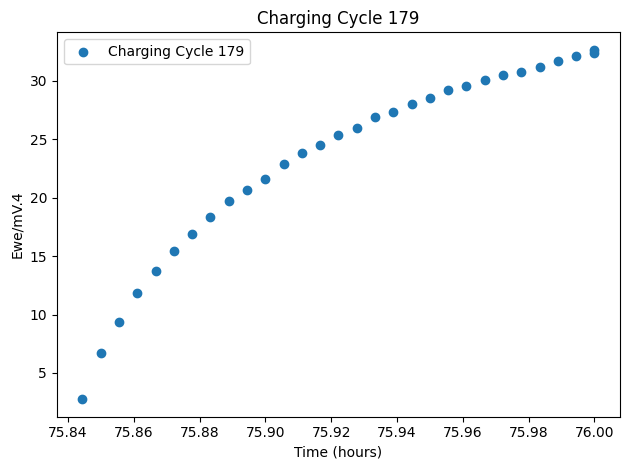

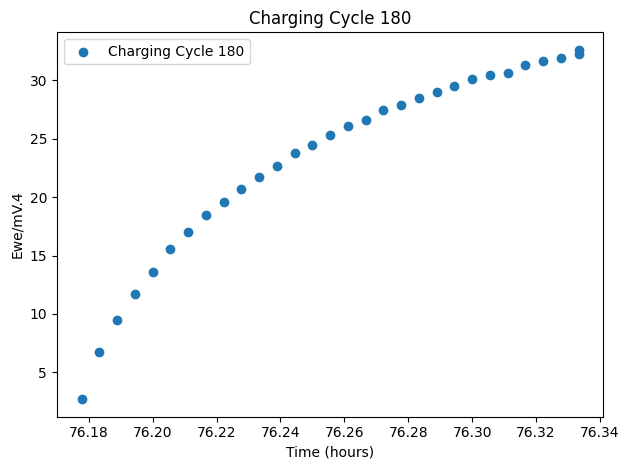

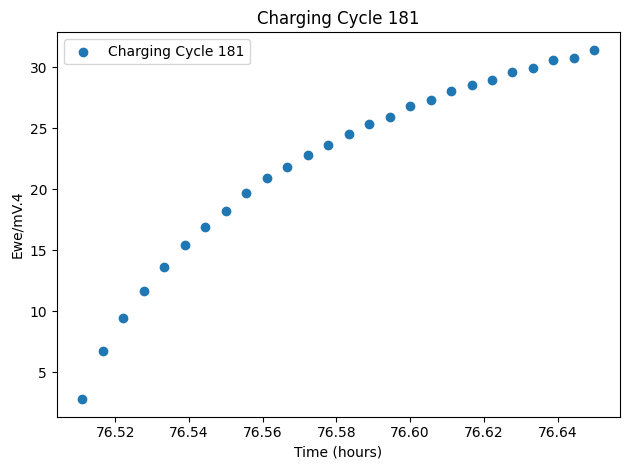

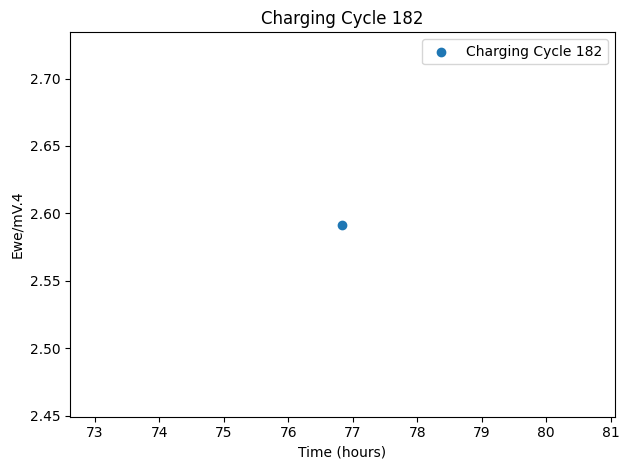

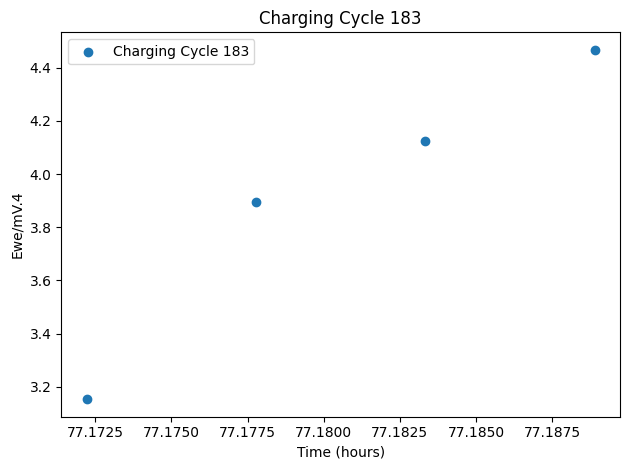

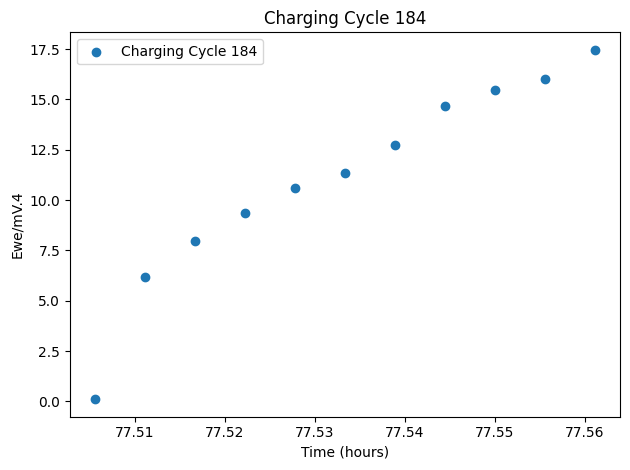

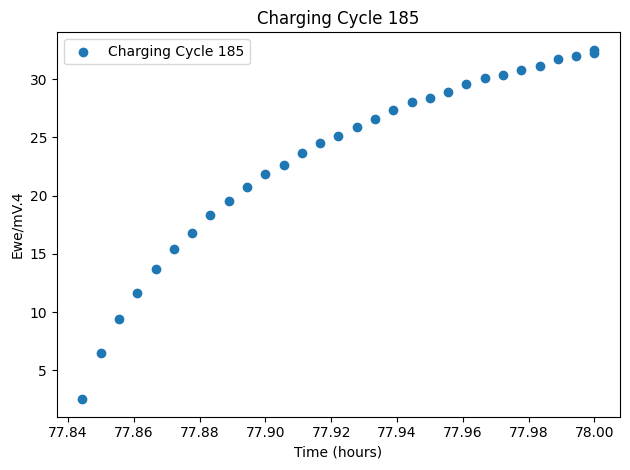

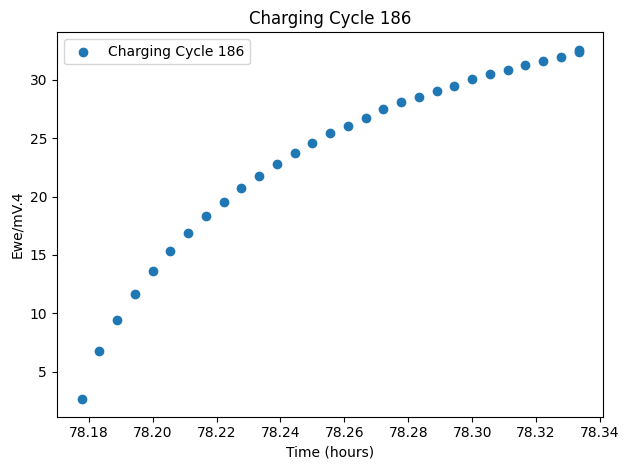

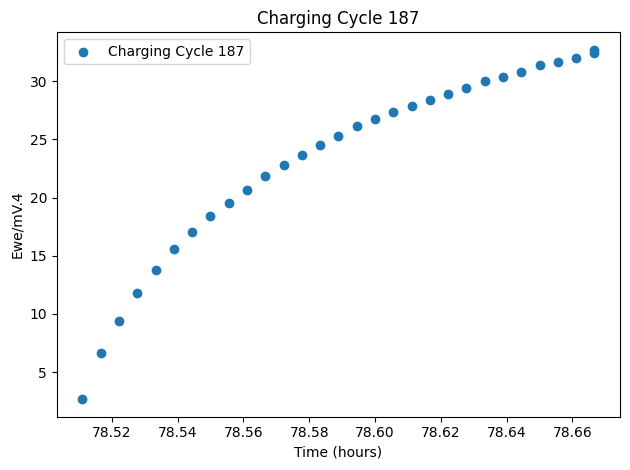

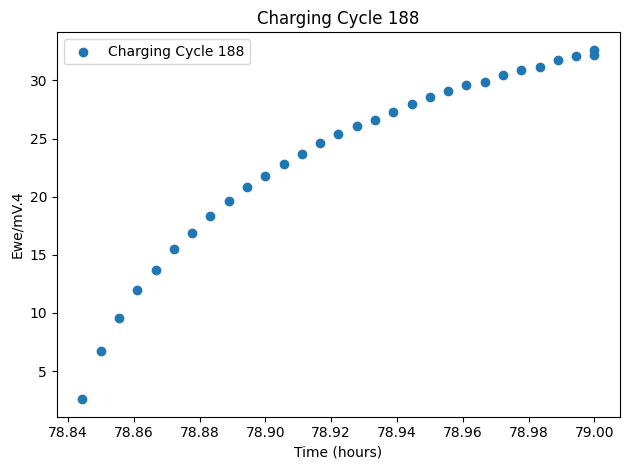

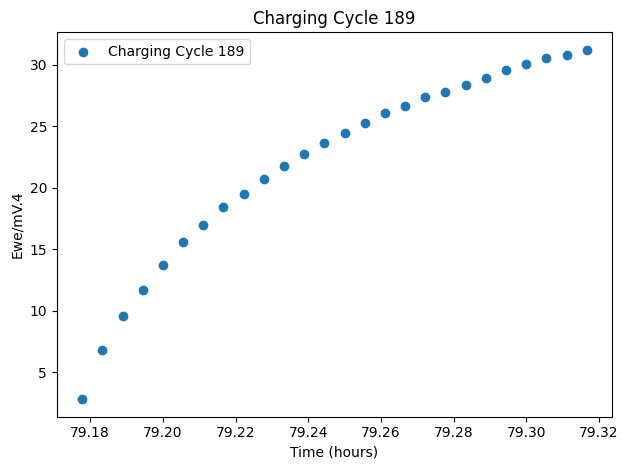

In [9]:
# Assuming the columns are 'time/hours' and 'Ewe/mV.4'
time_col = 'time/hours'
value_col = 'Ewe/mV.4'

charging_cycles = identify_charging_cycles(first_sheet_df, time_col, value_col)
        
# Plot each charging cycle as scatter plot
for idx, cycle in enumerate(charging_cycles):
    if idx < 189 and cycle:  # Ensure there's data to plot and index is less than 190
        times, values = zip(*cycle)
        plot_scatterplot(times, values, idx)

In [1]:
# Columns
time_col = 'time/hours'
value_col = 'Ewe/mV.4'

# Identify charging cycles
charging_cycles = identify_charging_cycles(first_sheet_df, time_col, value_col)

# Fit and plot each charging cycle
for idx, cycle in enumerate(charging_cycles):
    if idx < 190 and cycle:
        times, values = zip(*cycle)
        times, values, y_fitted, fitted_params = fit_model(np.array(times), np.array(values))
        plot_fitted(times, values, y_fitted, idx)
        print_fitted_params(fitted_params)


# Function to fit the model and plot
def fit_and_plot_cycle(times, values, idx):
    # Normalize the first_sheet_df to avoid overflow issues
    x_mean = np.mean(times)
    x_std = np.std(times)
    x_normalized = (times - x_mean) / x_std

    y_mean = np.mean(values)
    y_std = np.std(values)
    y_normalized = (values - y_mean) / y_std

    # Initial guesses for the parameters
    n_terms = 3  # Change this to the desired number of terms
    initial_guess = [0] + [1] * n_terms + [0.1] * n_terms

    # Define bounds for the parameters to avoid overflow issues
    lower_bounds = [-np.inf] + [-np.inf] * n_terms + [0] * n_terms
    upper_bounds = [np.inf] + [np.inf] * n_terms + [np.inf] * n_terms

    # Fit the model
    try:
        params, covariance = curve_fit(generalized_exponential_model, x_normalized, y_normalized, p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)
        fitted_params = params

        # Generate fitted values
        y_fitted_normalized = generalized_exponential_model(x_normalized, *fitted_params)

        # Convert fitted values back to original scale
        y_fitted = y_fitted_normalized * y_std + y_mean

        # Plot first_sheet_df and fitted model
        plt.figure()
        plt.scatter(times, values, label='first_sheet_df')
        plt.plot(times, y_fitted, label='Fitted Model (Gen Exp)', color='red')
        plt.xlabel('Time (hours)')
        plt.ylabel('Ewe/mV.4')
        plt.title(f'Charging Cycle {idx+1}')
        plt.legend()
        plt.show()

        # Print fitted parameters
        param_labels = ['c1'] + [f'c{i+2}' for i in range(n_terms)] + [f'b{i+2}' for i in range(n_terms)]
        for label, param in zip(param_labels, fitted_params):
            print(f'{label} = {param:.4f}')
    except Exception as e:
        print(f"Could not fit model for Charging Cycle {idx+1}: {e}")

# Apply the fitting and plotting function to each charging cycle
for idx, cycle in enumerate(charging_cycles):
    if idx < 190 and cycle:  # Ensure there's first_sheet_df to plot and index is less than 190
        times, values = zip(*cycle)
        fit_and_plot_cycle(np.array(times), np.array(values), idx)


NameError: name 'first_sheet_df' is not defined

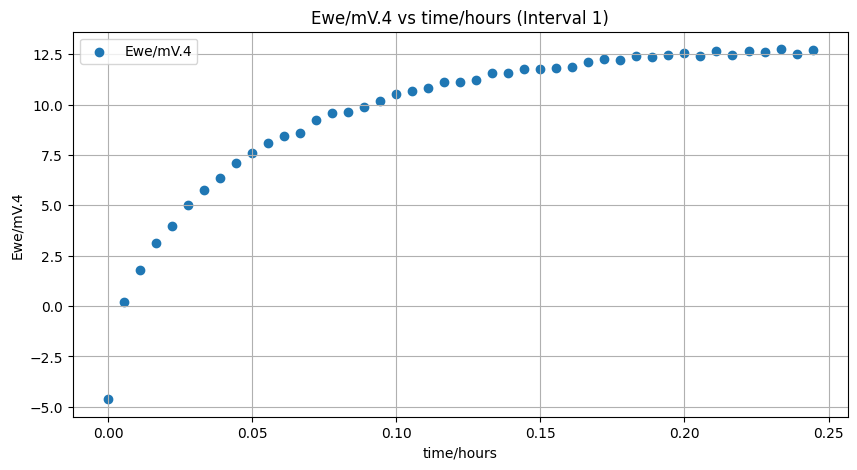

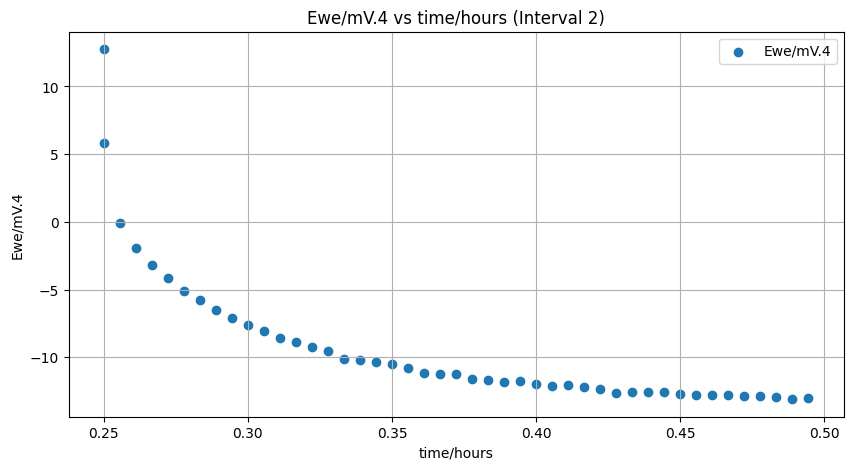

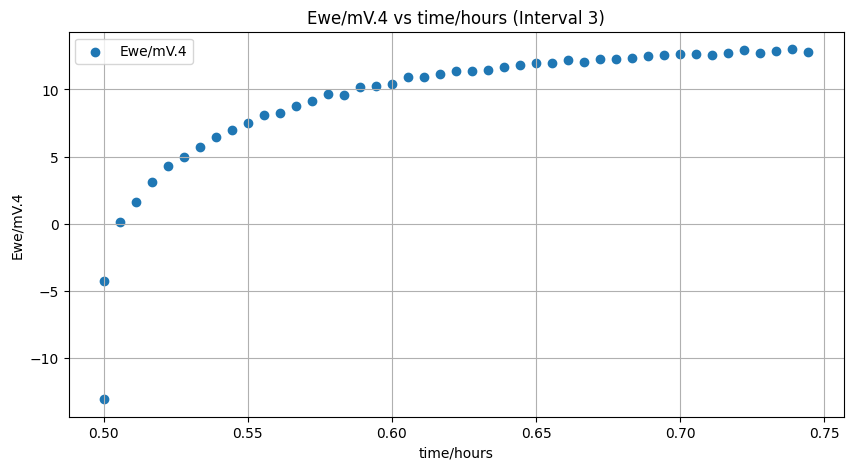

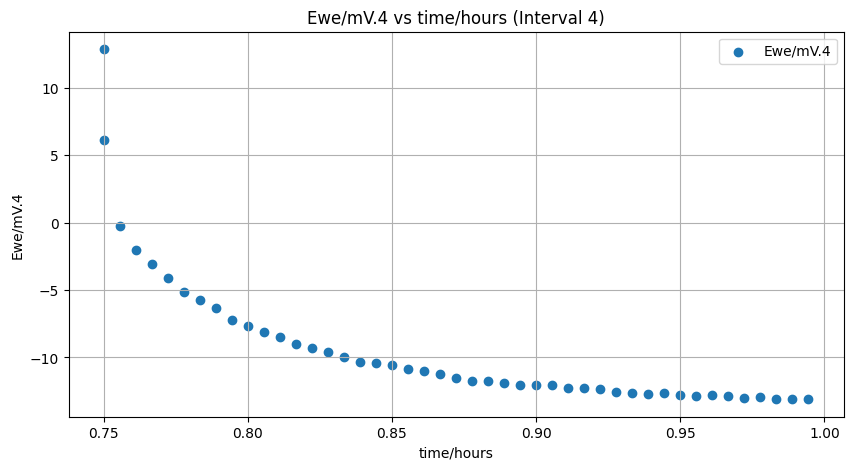

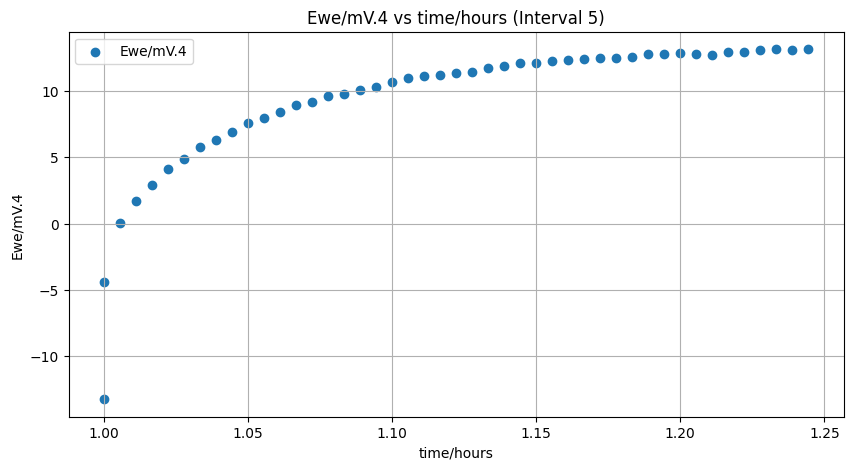

In [4]:
# Define the interval you want to divide your data into
interval = 0.249

# Define time column and columns to plot
time_column = 'time/hours'
columns_to_plot = ['Ewe/mV.4']

# Determine the number of plots needed based on the data length and interval
num_plots = int(len(first_sheet_df) / interval) + 1

# Plot each relevant column against 'time/hours' in separate figures
for i in range(5):  # Plotting the first five intervals
    plt.figure(figsize=(10, 5))
    
    # Calculate the start and end times for the current interval
    start_time = i * interval
    end_time = (i + 1) * interval
    
    # Slice the data within the current interval
    data_subset = first_sheet_df[(first_sheet_df[time_column] >= start_time) & 
                                 (first_sheet_df[time_column] < end_time)]
    
    for col in columns_to_plot:
        plt.scatter(data_subset[time_column], data_subset[col], label=col)
    
    plt.xlabel(time_column)
    plt.ylabel(columns_to_plot[0])  # Assuming only one column is plotted
    plt.title(f'{columns_to_plot[0]} vs {time_column} (Interval {i+1})')
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
# Define the response variable and predictor variable
y = fd['Ewe/mV.4'].values
x = fd['time/hours'].values

# Check for NaNs or infs
nan_mask = ~np.isnan(x) & ~np.isnan(y) & np.isfinite(x) & np.isfinite(y)
x = x[nan_mask]
y = y[nan_mask]

# Define the generalized exponential model
def generalized_exponential_model(t, a, b, c):
    return a * (1 - np.exp(-b * t)) + c

# Initial guesses for the parameters a, b, c
initial_guess = [max(y), 1, min(y)]

# Fit the model
params, covariance = curve_fit(generalized_exponential_model, x, y, p0=initial_guess, maxfev=2000)
a_fitted, b_fitted, c_fitted = params

# Generate fitted values
y_fitted = generalized_exponential_model(x, a_fitted, b_fitted, c_fitted)

# Plot data and fitted model
plt.scatter(x, y, label='Data')
plt.plot(x, y_fitted, label=f'Fitted Model (Gen Exp): a={a_fitted:.4f}, b={b_fitted:.4f}, c={c_fitted:.4f}', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Ewe/mV.4')
# plt.legend()
plt.show()


KeyboardInterrupt: 

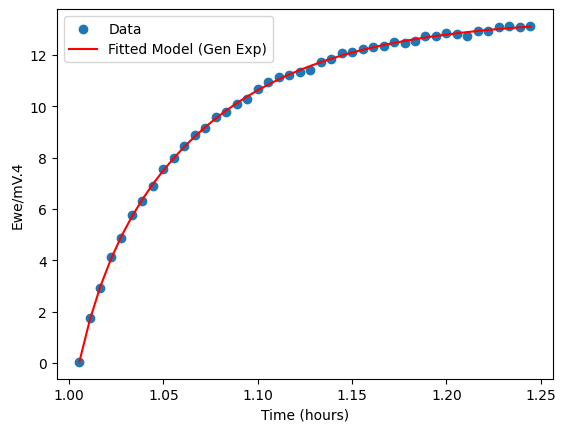

c1 = 0.9931
c2 = -0.0000
c3 = 5.7024
c4 = -0.5861
b2 = 1.0398
b3 = 0.0042
b4 = 0.0000


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming you have already loaded your data into fd
# Define the response variable and predictor variable
y = fd['Ewe/mV.4'].values
x = fd['time/hours'].values

# Check for NaNs or infs
nan_mask = ~np.isnan(x) & ~np.isnan(y) & np.isfinite(x) & np.isfinite(y)
x = x[nan_mask]
y = y[nan_mask]

# Normalize the data to avoid overflow issues
x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

# Define the generalized exponential model with multiple terms
def generalized_exponential_model(t, *params):
    # Assuming params = [c1, c2, b2, c3, b3, ..., cn, bn]
    n_terms = (len(params) - 1) // 2
    c1 = params[0]
    result = c1
    for i in range(n_terms):
        ci = params[1 + 2 * i]
        bi = params[2 + 2 * i]
        result += ci * np.exp(-bi * t)
    return result

# Initial guesses for the parameters
n_terms = 3  # Change this to the desired number of terms
initial_guess = [0] + [1] * n_terms + [0.1] * n_terms

# Define bounds for the parameters to avoid overflow issues
lower_bounds = [-np.inf] + [-np.inf] * n_terms + [0] * n_terms
upper_bounds = [np.inf] + [np.inf] * n_terms + [np.inf] * n_terms

# Fit the model
params, covariance = curve_fit(generalized_exponential_model, x_normalized, y_normalized, p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)
fitted_params = params

# Generate fitted values
y_fitted_normalized = generalized_exponential_model(x_normalized, *fitted_params)

# Convert fitted values back to original scale
y_fitted = y_fitted_normalized * y_std + y_mean

# Plot data and fitted model
plt.scatter(x, y, label='Data')
plt.plot(x, y_fitted, label='Fitted Model (Gen Exp)', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Ewe/mV.4')
plt.legend()
plt.show()

# Print fitted parameters
param_labels = ['c1'] + [f'c{i+2}' for i in range(n_terms)] + [f'b{i+2}' for i in range(n_terms)]
for label, param in zip(param_labels, fitted_params):
    print(f'{label} = {param:.4f}')


In [10]:
# # Define the response variable and predictor variable
# y = fd['Ewe/mV.4'].values
# x = fd['time/hours'].values

# # Check for NaNs or infs
# nan_mask = ~np.isnan(x) & ~np.isnan(y) & np.isfinite(x) & np.isfinite(y)
# x = x[nan_mask]
# y = y[nan_mask]

# # Define the generalized exponential model with one term
# def generalized_exponential_model(t, c1, c2, b2):
#     return c1 + c2 * np.exp(-b2 * t)

# # Initial guesses for the parameters
# initial_guess = [min(y), max(y)-min(y), 1]

# # Set bounds for the parameters
# lower_bounds = [-np.inf, 0, 0]
# upper_bounds = [np.inf, np.inf, np.inf]

# # Fit the model
# params, covariance = curve_fit(generalized_exponential_model, x, y, p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)
# fitted_params = params

# # Generate fitted values
# y_fitted = generalized_exponential_model(x, *fitted_params)

# # Plot data and fitted model
# plt.scatter(x, y, label='Data')
# plt.plot(x, y_fitted, label=f'Fitted Model (Gen Exp)', color='red')
# plt.xlabel('Time (hours)')
# plt.ylabel('Ewe/mV.4')
# plt.legend()
# plt.show()

# # Print fitted parameters
# param_labels = ['c1', 'c2', 'b2']
# for label, param in zip(param_labels, fitted_params):
#     print(f'{label} = {param:.4f}')

In [11]:
# # Define the generalized exponential model with multiple terms
# def generalized_exponential_model(t, c1, c2, b2, c3=0, b3=0):
#     return c1 + c2 * np.exp(-b2 * t) + c3 * np.exp(-b3 * t)

# # Initial guesses for the parameters
# initial_guess = [min(y), max(y)-min(y), 1, (max(y)-min(y))/2, 0.5]

# # Set bounds for the parameters
# lower_bounds = [-np.inf, 0, 0, 0, 0]
# upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]

# # Fit the model
# params, covariance = curve_fit(generalized_exponential_model, x, y, p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)
# fitted_params = params

# # Generate fitted values
# y_fitted = generalized_exponential_model(x, *fitted_params)

# # Plot data and fitted model
# plt.scatter(x, y, label='Data')
# plt.plot(x, y_fitted, label=f'Fitted Model (Gen Exp)', color='red')
# plt.xlabel('Time (hours)')
# plt.ylabel('Ewe/mV.4')
# plt.legend()
# plt.show()

# # Print fitted parameters
# param_labels = ['c1', 'c2', 'b2', 'c3', 'b3']
# for label, param in zip(param_labels, fitted_params):
#     print(f'{label} = {param:.4f}')


In [12]:
# # Define the exponential growth model
# def exponential_model(t, a, b):
#     return a * (1 - np.exp(-b * t))

# # Initial guesses for the parameters a and b
# initial_guess = [max(y), 1]

# # Fit the model
# params, covariance = curve_fit(exponential_model, x, y, p0=initial_guess, maxfev=2000)
# a_fitted, b_fitted = params

# # Generate fitted values
# y_fitted = exponential_model(x, a_fitted, b_fitted)

# # Plot data and fitted model
# plt.scatter(x, y, label='Data')
# plt.plot(x, y_fitted, label=f'Fitted Model (Exp): a={a_fitted:.4f}, b={b_fitted:.4f}', color='red')
# plt.xlabel('Time (hours)')
# plt.ylabel('Ewe/mV.4')
# plt.legend()
# plt.show()


In [13]:
# # Define the linear model
# def linear_model(t, m, c):
#     return m * t + c

# # Initial guesses for the parameters m and c
# initial_guess = [1, 0]

# # Fit the model
# params, covariance = curve_fit(linear_model, x, y, p0=initial_guess, maxfev=2000)
# m_fitted, c_fitted = params

# # Generate fitted values
# y_fitted = linear_model(x, m_fitted, c_fitted)

# # Plot data and fitted model
# plt.scatter(x, y, label='Data')
# plt.plot(x, y_fitted, label=f'Fitted Model (Linear): m={m_fitted:.4f}, c={c_fitted:.4f}', color='red')
# plt.xlabel('Time (hours)')
# plt.ylabel('Ewe/mV.4')
# plt.legend()
# plt.show()


In [14]:
# #calculate sse
# sse = np.sum((generalized_exponential_model.fittedvalues - first_sheet_df['Ewe/mV.4'])**2)
# print(sse)

# #calculate ssr
# ssr = np.sum((generalized_exponential_model.fittedvalues - first_sheet_df['Ewe/mV.4'].mean())**2)
# print(ssr)


# #calculate sst
# sst = ssr + sse
# print(sst)


### second_sheet (65C)

In [15]:
# Load the first sheet into a DataFrame
second_sheet_df = xls.parse(xls.sheet_names[1])

In [16]:
second_sheet_df = second_sheet_df[second_sheet_df['time/hours'] <= 0.25]

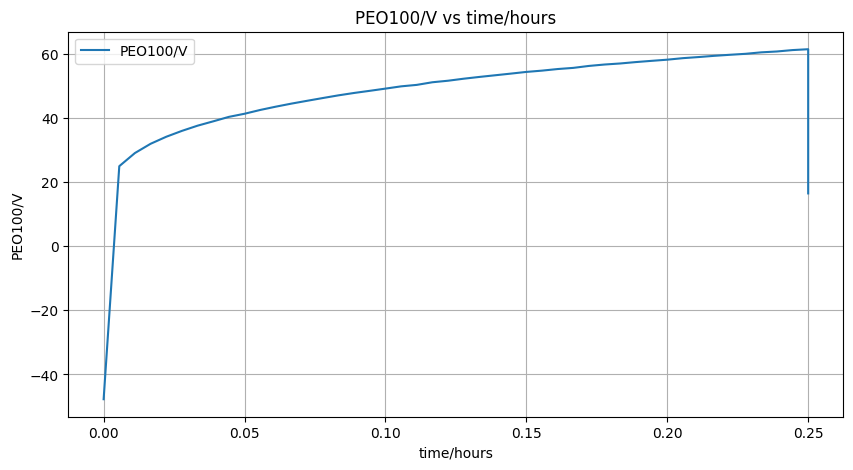

In [17]:
# Define time column and columns to plot
# time_column = ['time/s', 'time/s.2','time/hours', 'time/cycles']
time_column = ['time/hours']
columns_to_plot = ['PEO100/V']

# Plot each relevant column against 'time/hours'
for col in columns_to_plot:
    for time_col in time_column:
        plt.figure(figsize=(10, 5))
        plt.plot(second_sheet_df[time_col], second_sheet_df[col], label=col)
        plt.xlabel(time_col)
        plt.ylabel(col)
        plt.title(f'{col} vs {time_col}')
        plt.legend()
        plt.grid(True)
        plt.show()